In [1]:
import numpy as np 
import matplotlib.pyplot as plt


In [107]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import mat73
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from itertools import chain
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from pygam import LinearGAM
import matplotlib.cm as cm


%load_ext autoreload
%autoreload 2

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from GLM_regression import *
from GLM_regression_plotting import *
plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_SST = "SSTindivsomata_GLM"
filepath_SST = os.path.join(datasets_dir, filename_SST+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_NDNF = "NDNFindivsomata_GLM"
filepath_NDNF = os.path.join(datasets_dir, filename_NDNF+".mat")


datasets_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "datasets"))
filename_EC = "EC_GLM"
filepath_EC = os.path.join(datasets_dir, filename_EC+".mat")

activity_dict_SST, factors_dict_SST = preprocess_data(filepath_SST, normalize=True)
activity_dict_NDNF, factors_dict_NDNF = preprocess_data(filepath_NDNF, normalize=True)
activity_dict_EC, factors_dict_EC = preprocess_data(filepath_EC, normalize=True)

filtered_factors_dict_SST = subset_variables_from_data(factors_dict_SST, variables_to_keep=["Velocity"])
filtered_factors_dict_NDNF = subset_variables_from_data(factors_dict_NDNF, variables_to_keep=["Velocity"])
filtered_factors_dict_EC = subset_variables_from_data(factors_dict_EC, variables_to_keep=["Velocity"])


GLM_params_SST, predicted_activity_dict_SST = fit_GLM_population(filtered_factors_dict_SST, activity_dict_SST, quintile=None, regression='ridge', renormalize=True, alphas=None)

GLM_params_NDNF, predicted_activity_dict_NDNF = fit_GLM_population(filtered_factors_dict_NDNF, activity_dict_NDNF, quintile=None, regression='ridge', renormalize=True, alphas=None)
    
GLM_params_EC, predicted_activity_dict_EC = fit_GLM_population(filtered_factors_dict_EC, activity_dict_EC, quintile=None, regression='ridge', renormalize=True, alphas=None)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Msfin\AppData\Local\Temp\ipykernel_28012\1043544547.py:88: RuntimeWarning: divide by zero encountered in divide
  divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, np.nan)


MSE Between Ground Truth Place Field and Velcity-Subtracted Residuals 0.0799018000465746


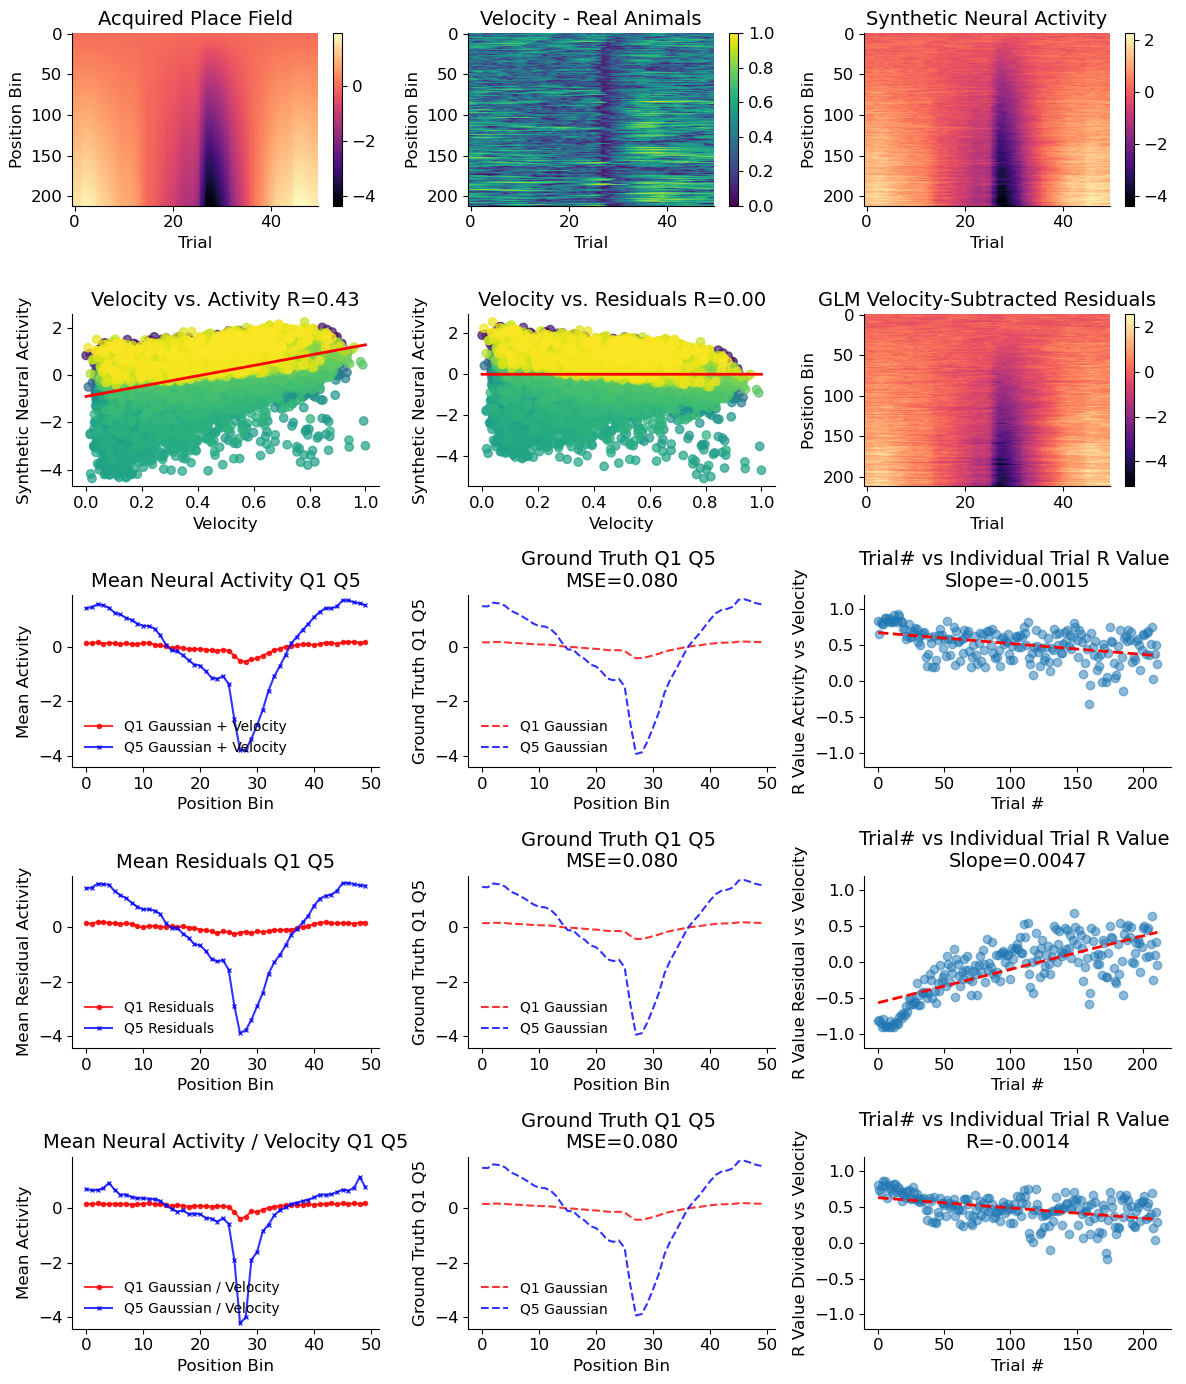

In [111]:
##### velocity plotted over cell trace



def plot_synthetic_data(weight_type, noise_sf, ramping_field=True, use_GAM=False, power=1, weight_scale=None):
    num_trials=212
    pf_scale = np.linspace(0, 1, num_trials)

    per_cell_velocity = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

    activity_list = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

    neurons_array = np.stack(activity_list) 
    combined_gaussian = np.mean(neurons_array, axis=0)
    num_trials = per_cell_velocity[0].shape[1]
    
    velocity = per_cell_velocity[0]
    
    if weight_type=="flat":
        weight = np.ones(num_trials)
    
    elif weight_type=="ramping_weight":
        weight = pf_scale
        
    elif weight_type=="step_weight":
        weight = np.zeros(num_trials)
        quint = len(weight) // 5  

        for i in range(5):
            weight[i * quint: (i + 1) * quint] = (i + 1) / 5

    weight = weight * weight_scale
  
    velocity_correlation = weight * velocity**(power) 
    
    
    a = np.tile(combined_gaussian, (num_trials, 1)).T

    if ramping_field:
        a = a * pf_scale
    
    noise = noise_sf * np.random.normal(0, 1, a.shape)
    
    a = (a-np.mean(a)) / np.std(a)
    
    combined_gaussian_with_velocity = a + velocity_correlation + noise
    std_dev = np.std(combined_gaussian_with_velocity)
    if std_dev == 0:
        combined_gaussian_with_velocity = combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)
    else:
        combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / std_dev
    
    
    ################# Fitting Model (GLM or GAM)
    
    neuron_activity_flat = combined_gaussian_with_velocity.flatten()
    flattened_data = velocity.flatten().reshape(-1, 1)  # Ensure shape compatibility

    if use_GAM:
        # Fit a Generalized Additive Model (GAM)
        model = LinearGAM().fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)
    else:
        # Fit a Generalized Linear Model (GLM) using Ridge Regression
        alphas = [0.1, 1, 10, 100, 1000, 5000]
        model = RidgeCV(alphas=alphas, cv=None)
        model.fit(flattened_data, neuron_activity_flat)
        neuron_predicted_activity = model.predict(flattened_data)

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)

    ################## Plotting Residuals
    
    residual = combined_gaussian_with_velocity - neuron_predicted_activity

    ################## plotting quintiles 


    num_trials = residual.shape[1] 
    quintile_size = num_trials // 5
    
    divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, np.nan)
    divide_data_by_velocity = np.nan_to_num(divide_data_by_velocity, nan=0)
    
    combined_gaussian_with_velocity = z_score_check_and_normalize(combined_gaussian_with_velocity, "Combined Gaussian with Velocity")
#     velocity = z_score_check_and_normalize(velocity, "Velocity")
    residual = z_score_check_and_normalize(residual, "Residuals")
    divide_data_by_velocity = z_score_check_and_normalize(divide_data_by_velocity, "Velocity-Subtracted Activity")


    residual_q1 = residual[:, :quintile_size]  
    residual_q5 = residual[:, -quintile_size:] 

    gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
    gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]

    divided_q1 = divide_data_by_velocity[:, :quintile_size]
    divided_q5 = divide_data_by_velocity[:, -quintile_size:]

    mean_residual_q1 = np.mean(residual_q1, axis=1)
    mean_residual_q5 = np.mean(residual_q5, axis=1)

    mean_gaussian_q1 = np.mean(gaussian_q1, axis=1)
    mean_gaussian_q5 = np.mean(gaussian_q5, axis=1)
    
    mean_divided_q1 = np.mean(divided_q1, axis=1)
    mean_divided_q5 = np.mean(divided_q5, axis=1)
    

    ################## overall correlations

    flat_velocity = velocity.flatten()
    flat_activity = combined_gaussian_with_velocity.flatten()

    velocity_activity_correlation, _ = pearsonr(flat_velocity, flat_activity)

    slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)

    x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals = slope * x_vals + intercept


    flat_residual = residual.flatten()

    velocity_residual_correlation, _ = pearsonr(flat_velocity, flat_residual)
    slope_pred, intercept_pred, r_value_pred, p_value_pred, std_err_pred = linregress(flat_velocity, flat_residual)

    x_vals_pred = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals_pred = slope_pred * x_vals_pred + intercept_pred


    ################### Trial by trial correlations 

    prediction_velocity_correlation_list = []
    activity_velocity_correlation_list = []
    residual_velocity_correlation_list = []
    divided_velocity_correlation_list = []

    for i in range(neuron_predicted_activity.shape[1]):
        trial_predicted_activity = neuron_predicted_activity[:, i]
        trial_velocity = velocity[:, i]
        trial_activity = combined_gaussian_with_velocity[:, i]
        trial_residual = residual[:, i]
        trial_divided = divide_data_by_velocity[:, i]

        prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
        prediction_velocity_correlation_list.append(prediction_velocity_correlation)
        
        activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
        activity_velocity_correlation_list.append(activity_velocity_correlation)
        
        residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
        residual_velocity_correlation_list.append(residual_velocity_correlation)
        
        divided_velocity_correlation, _ = pearsonr(trial_divided, trial_velocity)
        divided_velocity_correlation_list.append(divided_velocity_correlation)

    #############################

    ground_truth_q1 = a[:, :quintile_size]
    ground_truth_q5 = a[:, -quintile_size:]

    mean_truth_q1 = np.mean(ground_truth_q1, axis=1)
    mean_truth_q5 = np.mean(ground_truth_q5, axis=1)

    fig, axs = plt.subplots(5, 3, figsize=(12, 14))  

    im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
    axs[0, 0].set_xlabel("Trial", fontsize=12)
    axs[0, 0].set_ylabel("Position Bin", fontsize=12)
    if ramping_field:
        axs[0, 0].set_title("Acquired Place Field", fontsize=14)
    else:
        axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
    fig.colorbar(im1, ax=axs[0, 0])
    
    MSE = (a-residual)**2
    MSE = np.mean(MSE)
    print(f"MSE Between Ground Truth Place Field and Velcity-Subtracted Residuals {MSE}")

    im3 = axs[0, 1].imshow(velocity.T, cmap='viridis', aspect='auto')
    axs[0, 1].set_title("Velocity - Real Animals", fontsize=14)
    axs[0, 1].set_xlabel("Trial", fontsize=12)
    axs[0, 1].set_ylabel("Position Bin", fontsize=12)
    fig.colorbar(im3, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
    axs[0, 2].set_xlabel("Trial", fontsize=12)
    axs[0, 2].set_ylabel("Position Bin", fontsize=12)
    axs[0, 2].set_title("Synthetic Neural Activity", fontsize=14)
    fig.colorbar(im2, ax=axs[0, 2])

    num_points, num_trials = velocity.shape
    trial_colors = np.repeat(np.linspace(0,1,num_trials), num_points)
    
    cmap = plt.colormaps.get_cmap("viridis")
 
    sc = axs[1, 0].scatter(flat_velocity, flat_activity, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 0].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 0].set_xlabel("Velocity", fontsize=12)
    axs[1, 0].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 0].set_title(f"Velocity vs. Activity R={velocity_activity_correlation:.2f}", fontsize=14)


    sc = axs[1, 1].scatter(flat_velocity, flat_residual, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 1].plot(x_vals_pred, y_vals_pred, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 1].set_xlabel("Velocity", fontsize=12)
    axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 1].set_title(f"Velocity vs. Residuals R={velocity_residual_correlation:.2f}", fontsize=14)

    im5 = axs[1, 2].imshow(residual.T, cmap='magma', aspect='auto')
    axs[1, 2].set_xlabel("Trial", fontsize=12)
    axs[1, 2].set_ylabel("Position Bin", fontsize=12)
    axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
    fig.colorbar(im5, ax=axs[1, 2])


    data_list1 = [mean_gaussian_q1, mean_gaussian_q5, mean_residual_q1, mean_residual_q5, mean_divided_q1, mean_divided_q5]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data1 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data1 = np.min(min_list)
    
    data_list2 = [activity_velocity_correlation_list, residual_velocity_correlation_list, divided_velocity_correlation_list]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data2 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data2 = np.min(min_list)
    
    
    mean_corr_activity = np.mean(activity_velocity_correlation_list)
    mean_corr_residual = np.mean(residual_velocity_correlation_list)
    mean_corr_divide = np.mean(divided_velocity_correlation_list)

    axs[2, 0].plot(mean_gaussian_q1, color='r', label="Q1 Gaussian + Velocity", marker='o', markersize=3, alpha=0.8)
    axs[2, 0].plot(mean_gaussian_q5, color='b', label="Q5 Gaussian + Velocity", marker='x', markersize=3, alpha=0.8)
    axs[2, 0].set_xlabel("Position Bin", fontsize=12)
    axs[2, 0].set_ylabel("Mean Activity", fontsize=12)
    axs[2, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
    axs[2, 0].set_ylim(min_data1-0.2, max_data1+0.2)
    axs[2, 0].legend(fontsize=10)

    axs[2, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[2, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[2, 1].set_xlabel("Position Bin", fontsize=12)
    axs[2, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[2, 1].set_title(f"Ground Truth Q1 Q5 \nMSE={MSE:.3f}", fontsize=14)
    axs[2, 1].set_ylim(min_data1-0.2, max_data1+0.2)
    axs[2, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(activity_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers

    axs[2, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
    axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[2, 2].set_xlabel("Trial #", fontsize=12)
    axs[2, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
    axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nSlope={slope:.4f}", fontsize=14)
    axs[2, 2].set_ylim(-1.2, 1.2)
    
    axs[3, 0].plot(mean_residual_q1, color='r', label="Q1 Residuals", marker='o', markersize=3, alpha=0.8)
    axs[3, 0].plot(mean_residual_q5, color='b', label="Q5 Residuals", marker='x', markersize=3, alpha=0.8)
    axs[3, 0].set_xlabel("Position Bin", fontsize=12)
    axs[3, 0].set_ylabel("Mean Residual Activity", fontsize=12)
    axs[3, 0].set_title("Mean Residuals Q1 Q5", fontsize=14)
    axs[3, 0].set_ylim(min_data2-0.2, max_data2+0.2)
    axs[3, 0].legend(fontsize=10)

    axs[3, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[3, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[3, 1].set_xlabel("Position Bin", fontsize=12)
    axs[3, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[3, 1].set_title(f"Ground Truth Q1 Q5 \nMSE={MSE:.3f}", fontsize=14)
    axs[3, 1].set_ylim(min_data1-0.2, max_data1+0.2)
    axs[3, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(residual_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    residual_corr_array = np.array(residual_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

    axs[3, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
    axs[3, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[3, 2].set_xlabel("Trial #", fontsize=12)
    axs[3, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
    axs[3, 2].set_title(f"Trial# vs Individual Trial R Value \nSlope={slope:.4f}", fontsize=14)
    axs[3, 2].set_ylim(-1.2, 1.2)


#############  Dividing by velocity - Christines original model 
    
    axs[4, 0].plot(mean_divided_q1, color='r', label="Q1 Gaussian / Velocity", marker='o', markersize=3, alpha=0.8)
    axs[4, 0].plot(mean_divided_q5, color='b', label="Q5 Gaussian / Velocity", marker='x', markersize=3, alpha=0.8)
    axs[4, 0].set_xlabel("Position Bin", fontsize=12)
    axs[4, 0].set_ylabel("Mean Activity", fontsize=12)
    axs[4, 0].set_title("Mean Neural Activity / Velocity Q1 Q5", fontsize=14)
    axs[4, 0].set_ylim(min_data2-0.2, max_data2+0.2)
    axs[4, 0].legend(fontsize=10)
    
    axs[4, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Gaussian", alpha=0.8)
    axs[4, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Gaussian", alpha=0.8)
    axs[4, 1].set_xlabel("Position Bin", fontsize=12)
    axs[4, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[4, 1].set_title(f"Ground Truth Q1 Q5 \nMSE={MSE:.3f}", fontsize=14)
    axs[4, 1].set_ylim(min_data1-0.2, max_data1+0.2)
    axs[4, 1].legend(fontsize=10)
    
    trial_numbers=np.arange(len(divided_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, divided_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    divided_corr_array = np.array(divided_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, divided_corr_array)

    axs[4, 2].scatter(trial_numbers, divided_velocity_correlation_list, alpha=0.5, label="Data")
    axs[4, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[4, 2].set_xlabel("Trial #", fontsize=12)
    axs[4, 2].set_ylabel("R Value Divided vs Velocity", fontsize=12)
    axs[4, 2].set_title(f"Trial# vs Individual Trial R Value \nR={slope:.4f}", fontsize=14)
    axs[4, 2].set_ylim(-1.2, 1.2)

    

    plt.tight_layout() 
    plt.show()

plot_synthetic_data(weight_type="flat", noise_sf=0.1, ramping_field=True, use_GAM=False, power=1, weight_scale=1)

#flat
#weight="ramping_weight
#weight="step_weight
#### ramping wt still linear just chaning in scale with trial

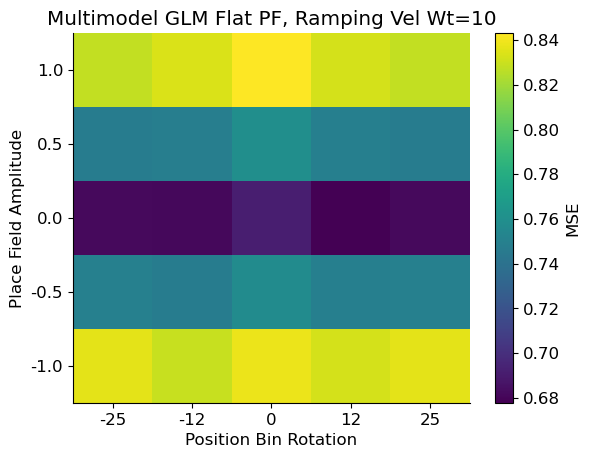

In [186]:

def z_score_check_and_normalize(data, label):

    mean = np.mean(data)
    std = np.std(data)

    if np.isclose(mean, 0, atol=1e-2) and np.isclose(std, 1, atol=1e-2):
        return data  # No need to normalize
    elif std > 0:
        return (data - mean) / std  # Normalize
    else:
        return np.zeros_like(data)  # If variance is zero, return a zero array


def get_MSE_per_model(activity_dict_SST, cell_type="SST", weight_type="flat", noise_sf=0., ramping_field=True, use_GAM=False, power=1, weight_scale=10, field_rotation_factor=0, place_field_sf=1, multimodel=False):
    
    per_cell_velocity = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

    activity_list = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

            
    neurons_array = np.stack(activity_list) 
    combined_gaussian = np.mean(neurons_array, axis=0)
    num_trials = per_cell_velocity[0].shape[1]
    pf_scale = np.linspace(0, place_field_sf, num_trials)

    velocity = per_cell_velocity[0]
    
    if weight_type=="flat":
        weight = np.ones(num_trials)
    
    elif weight_type=="ramping_weight":
        weight = pf_scale
        
    elif weight_type=="step_weight":
        weight = np.zeros(num_trials)
        quint = len(weight) // 5  

        for i in range(5):
            weight[i * quint: (i + 1) * quint] = (i + 1) / 5

    weight = weight * weight_scale
    velocity_correlation = weight * velocity**(power) 
    
    if cell_type=="SST":
         
        num_trials=per_cell_velocity[0].shape[1]
        pf_scale = np.linspace(0, 1, num_trials)

        activity_list = []
        for animal in activity_dict_SST:
            for neuron in activity_dict_SST[animal]:
                activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

        neurons_array = np.stack(activity_list) 
        combined_gaussian = np.mean(neurons_array, axis=0)
        
    elif cell_type=="NDNF":

        num_trials=per_cell_velocity[0].shape[1]
        pf_scale = np.linspace(0, 1, num_trials)

        activity_list = []
        for animal in activity_dict_NDNF:
            for neuron in activity_dict_NDNF[animal]:
                activity_list.append(np.mean(activity_dict_NDNF[animal][neuron], axis=1))

        neurons_array = np.stack(activity_list) 
        combined_gaussian = np.mean(neurons_array, axis=0)

    
    combined_gaussian = np.roll(combined_gaussian, shift=field_rotation_factor, axis=0)
    
    a = np.tile(combined_gaussian, (num_trials, 1)).T

    if ramping_field:
        a = a * pf_scale

    
    noise = noise_sf * np.random.normal(0, 1, a.shape)  
        
    combined_gaussian_with_velocity = a + velocity_correlation + noise
    std_dev = np.std(combined_gaussian_with_velocity)
    if std_dev == 0:
        combined_gaussian_with_velocity = combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)
    else:
        combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / std_dev
    

    ################# Fitting Model (GLM or GAM)
    
    neuron_activity_flat = combined_gaussian_with_velocity.flatten()
    flattened_data = velocity.flatten().reshape(-1, 1)  # Ensure shape compatibility
    
    quintile_size = num_trials // 5 
    
    if multimodel:
        gaussian_quintiles = [] 
        velocity_quintiles = []
        ground_truth_qunitles_list = []

        for i in range(5):  
            start_idx = i * quintile_size 
            end_idx = (num_trials if i == 4 else (i + 1) * quintile_size)  


            gaussian_quintile = combined_gaussian_with_velocity[:, start_idx:end_idx] 
            gaussian_quintiles.append(gaussian_quintile) 

            velocity_quintile = velocity[:, start_idx:end_idx] 
            velocity_quintiles.append(velocity_quintile)

            ground_truth_qunitle = a[:, start_idx:end_idx]
            ground_truth_qunitles_list.append(ground_truth_qunitle)


        residual_list = []
        predicted_list = []

        for i in range(5):
            gaussian_quintile  = gaussian_quintiles[i]
            velocity_quintile = velocity_quintiles[i]

            neuron_activity_flat = gaussian_quintile.flatten()
            flattened_velocity = velocity_quintile.flatten().reshape(-1, 1)  

            if use_GAM:
                model = LinearGAM().fit(flattened_velocity, neuron_activity_flat)
                neuron_predicted_activity = model.predict(flattened_velocity)

            else:
                alphas = [0.1, 1, 10, 100, 1000, 5000]
                model = RidgeCV(alphas=alphas, cv=None)
                model.fit(flattened_velocity, neuron_activity_flat)
                neuron_predicted_activity = model.predict(flattened_velocity)


            neuron_predicted_activity = neuron_predicted_activity.reshape(velocity_quintile.shape)

            residual = gaussian_quintile - neuron_predicted_activity

            residual_list.append(z_score_check_and_normalize(residual, "Residuals"))
            predicted_list.append(z_score_check_and_normalize(neuron_predicted_activity, "Prediction"))


        residual_array = np.concatenate(residual_list, axis=1)
        predicted_array = np.concatenate(predicted_list, axis=1)
        
        MSE = (a-residual_array)**2
        MSE = np.mean(MSE)
        

    else:
        if use_GAM:
            # Fit a Generalized Additive Model (GAM)
            model = LinearGAM().fit(flattened_data, neuron_activity_flat)
            neuron_predicted_activity = model.predict(flattened_data)
        else:
            # Fit a Generalized Linear Model (GLM) using Ridge Regression
            alphas = [0.1, 1, 10, 100, 1000, 5000]
            model = RidgeCV(alphas=alphas, cv=None)
            model.fit(flattened_data, neuron_activity_flat)
            neuron_predicted_activity = model.predict(flattened_data)

        neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    
        residual = combined_gaussian_with_velocity - neuron_predicted_activity

        MSE = (a-residual)**2
        MSE = np.mean(MSE)
        
#     print(f"weight_type {weight_type}")
#     print(f"noise_sf {noise_sf}")
#     print(f"ramping_field {ramping_field}")
#     print(f"use_GAM {use_GAM}")
#     print(f"weight_scale {weight_scale}")
#     print(f"field_rotation_factor {field_rotation_factor}")
#     print(f"place_field_sf {place_field_sf}")
#     print(f"multimodel {multimodel}")
    
    return MSE, a, combined_gaussian_with_velocity

def get_MSE_array_and_plot(activity_dict_SST, cell_type="SST", weight_type="flat", noise_sf=0., ramping_field=True, use_GAM=False, power=1, weight_scale=1, multimodel=False):
    rotation_array = np.array([-25, -12, 0, 12, 25])
    pf_amplitude_list = [1.0, 0.5, 0., -0.5, -1.0]

    y_labels = [str(a) for a in pf_amplitude_list]
    x_labels = [str(r) for r in rotation_array]

    overall_modulation_list = []
    for i in rotation_array:
        aplitude_list = []
        for j in pf_amplitude_list:
            MSE, a, combined_gaussian_with_velocity = get_MSE_per_model(activity_dict_SST, cell_type="SST", weight_type=weight_type, noise_sf=noise_sf, ramping_field=ramping_field, use_GAM=use_GAM, power=power, weight_scale=weight_scale, field_rotation_factor=i, place_field_sf=j, multimodel=multimodel)
            aplitude_list.append(MSE)
        overall_modulation_list.append(aplitude_list)

    test_array = np.array(overall_modulation_list)

    plt.imshow(test_array.T, aspect="auto")
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.xlabel("Position Bin Rotation")
    plt.ylabel("Place Field Amplitude")
    if ramping_field:
        if weight_type=="flat":
            if multimodel:
                if use_GAM:
                    plt.title(f"Multimodel GAM Ramping PF, Flat Vel Wt={weight_scale}")
                else:
                    plt.title(f"Multimodel GLM Ramping PF, Flat Vel Wt={weight_scale}")
            else:
                if use_GAM:
                    plt.title(f"Single Model GAM Ramping PF, Flat Vel Wt={weight_scale}")
                else:
                    plt.title(f"Single Model GLM Ramping PF, Flat Vel Wt={weight_scale}")
        else:
            if multimodel:
                if use_GAM:
                    plt.title(f"Multimodel GAM Ramping PF, Ramping Vel Wt={weight_scale}")
                else:
                    plt.title(f"Multimodel GLM Ramping PF, Ramping Vel Wt={weight_scale}")
            else:
                if use_GAM:
                    plt.title(f"Single Model GAM Ramping PF, Ramping Vel Wt={weight_scale}")
                else:
                    plt.title(f"Single Model GLM Ramping PF, Ramping Vel Wt={weight_scale}")
    else:
        if weight_type=="flat":
            if multimodel:
                if use_GAM:
                    plt.title(f"Multimodel GAM Flat PF, Flat Vel Wt={weight_scale}")
                else:
                    plt.title(f"Multimodel GLM Flat PF, Flat Vel Wt={weight_scale}")
            else:
                if use_GAM:
                    plt.title(f"Single Model GAM Flat PF, Flat Vel Wt={weight_scale}")
                else:
                    plt.title(f"Single Model GLM Flat PF, Flat Vel Wt={weight_scale}")
        else:
            if multimodel:
                if use_GAM:
                    plt.title(f"Multimodel GAM Flat PF, Ramping Vel Wt={weight_scale}")
                else:
                    plt.title(f"Multimodel GLM Flat PF, Ramping Vel Wt={weight_scale}")
            else:
                if use_GAM:
                    plt.title(f"Single Model GAM Flat PF, Ramping Vel Wt={weight_scale}")
                else:
                    plt.title(f"Single Model GLM Flat PF, Ramping Vel Wt={weight_scale}")
                

    plt.colorbar(label="MSE")
    plt.show()

get_MSE_array_and_plot(activity_dict_SST, cell_type="SST", weight_type="ramping_weight", noise_sf=0., ramping_field=False, use_GAM=False, power=1, weight_scale=10, multimodel=True)
    

    
    


In [ ]:
############################# getting the kernel that convolves velocoity to get activity

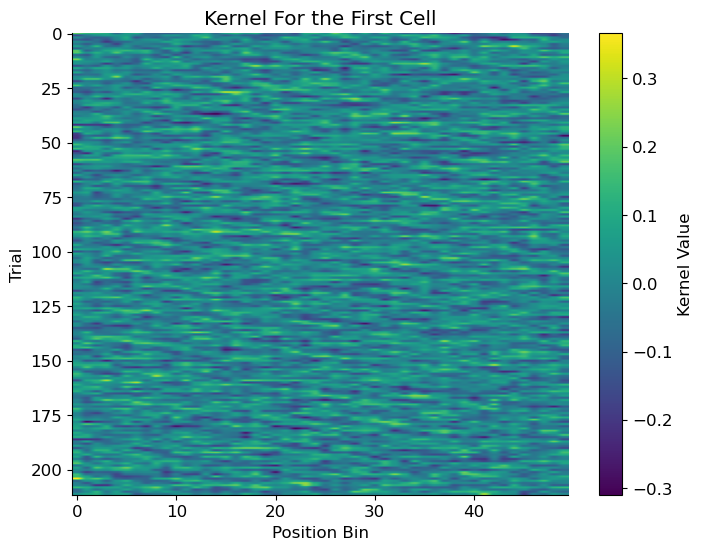

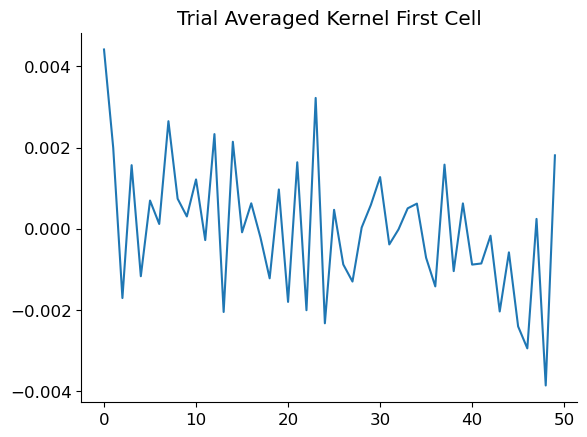

(75, 50)


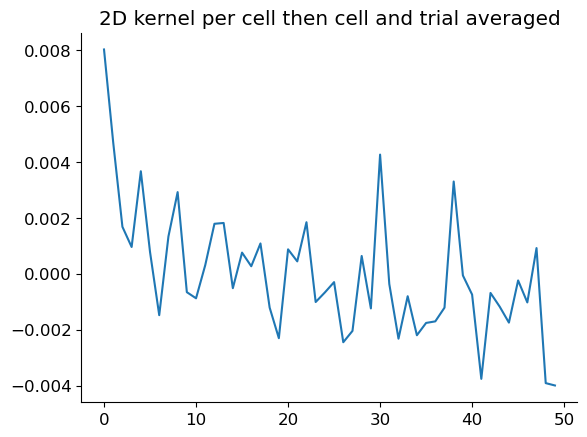

In [68]:

def deconvolve_kernel(neural_activity, velocity, reg_factor=1e-6):

    SF = np.fft.fft2(neural_activity)
    FF = np.fft.fft2(velocity)
    
    GF = SF / (FF + reg_factor)

    kernel = np.fft.ifft2(GF).real  
    
    return kernel


per_cell_velocity = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

activity_list = []
for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(activity_dict_SST[animal][neuron])

        
kernel = deconvolve_kernel(activity_list[0], per_cell_velocity[0])


plt.figure(figsize=(8, 6))
plt.imshow(kernel.T, aspect="auto", cmap="viridis")
plt.colorbar(label="Kernel Value")
plt.xlabel("Position Bin")
plt.ylabel("Trial")
plt.title("Kernel For the First Cell")
plt.show()

plt.figure()
plt.plot(np.mean(kernel, axis=1))
plt.title("Trial Averaged Kernel First Cell")
plt.xlabel("Position Bin")
plt.show()

############### getting a kernel for each cell and then taking the average of that 

kernel_list = []

for i in range(len(activity_list)):
    neural_activity = activity_list[i]
    velocity = per_cell_velocity[i]
    kernel = deconvolve_kernel(neural_activity, velocity, reg_factor=1e-6)
    kernel_list.append(np.mean(kernel, axis=1))
    
kernel_array = np.array(kernel_list)
print(kernel_array.shape)
cell_average_kernel = np.mean(kernel_array, axis=0)

plt.figure()
plt.plot(cell_average_kernel)
plt.title("2D kernel per cell then cell and trial averaged")
plt.xlabel("Position Bin")
plt.show()

    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

def make_exp_kernel(length=50, decay_rate=0.1):
    """Generate an exponentially decaying kernel with AUC=1."""
    t = np.arange(length)
    kernel = np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)  # Normalize AUC to 1
    return kernel

def deconvolve_kernel_1d(neural_activity, velocity, reg_factor=1e-6):
    """Perform Fourier deconvolution to extract the kernel G for 1D arrays."""
    
    neural_activity = neural_activity.flatten()
    velocity = velocity.flatten()
    
    SF = np.fft.fft(neural_activity)
    FF = np.fft.fft(velocity)
    
    GF = SF / (FF + reg_factor)
    
    kernel = np.fft.ifft(GF).real  # Take real part
    return kernel

# Step 1: Create a known kernel
true_kernel = make_exp_kernel(length=50, decay_rate=0.1)

# Step 2: Generate a velocity signal (random walk)
T = 500  # Total time points
np.random.seed(42)
velocity_1d = np.cumsum(np.random.randn(T))  # Simulated velocity (random walk)

# Step 3: Convolve velocity with the kernel to get neural activity
neural_activity_1d = convolve(velocity_1d, true_kernel, mode="same")

# Step 4: Recover the kernel using deconvolution
recovered_kernel = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)

# Step 5: Plot true vs recovered kernel
plt.figure(figsize=(8, 4))
plt.plot(true_kernel, label="True Kernel", color="blue", linestyle="--")
plt.plot(recovered_kernel[:50], label="Recovered Kernel", color="purple")
plt.xlabel("Time Index")
plt.ylabel("Kernel Value")
plt.title("True vs Recovered Kernel via Fourier Deconvolution")
plt.legend()
plt.show()


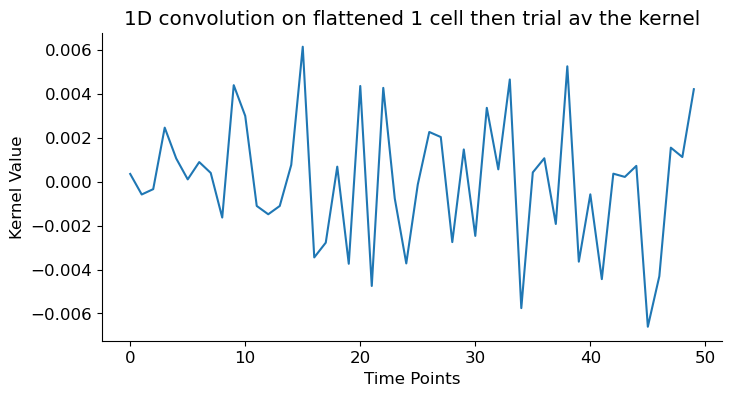

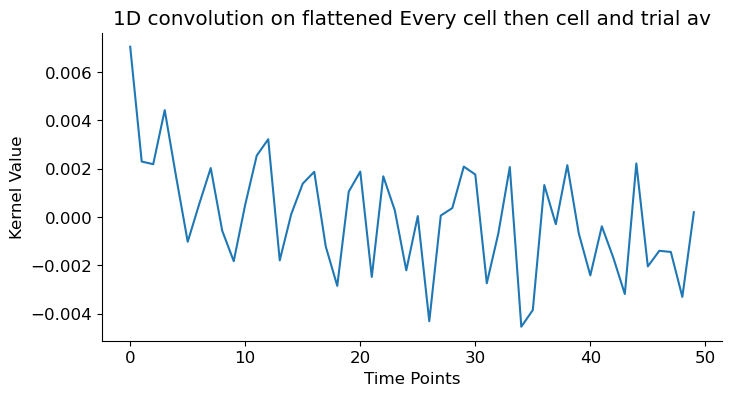

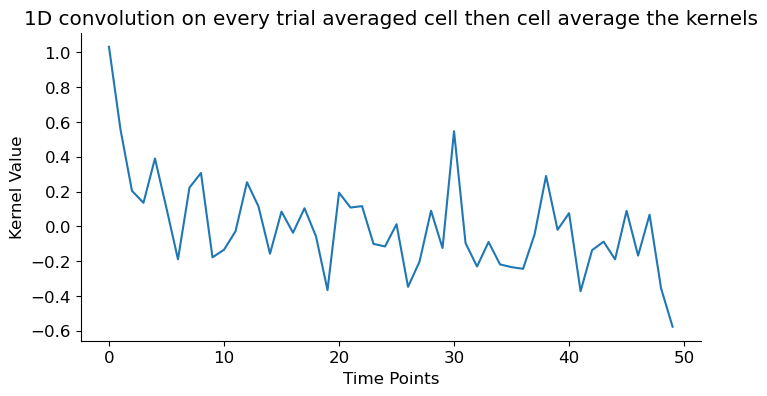

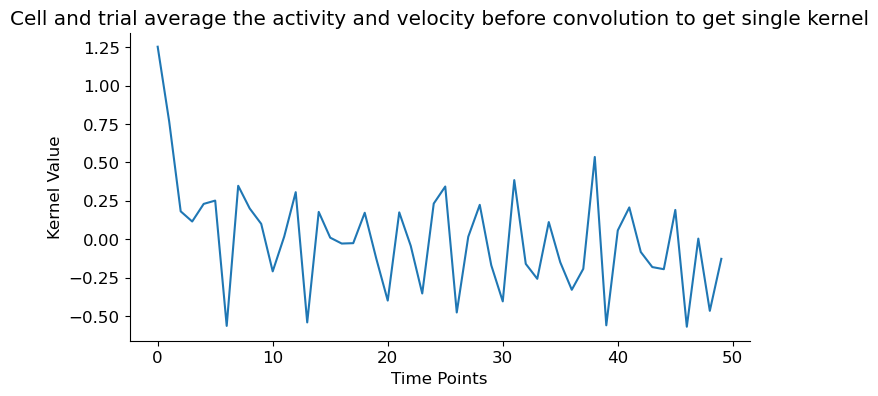

In [85]:

def deconvolve_kernel_1d(neural_activity, velocity, reg_factor=1e-6):
    
    neural_activity = neural_activity.flatten()
    velocity = velocity.flatten()
    
    
    SF = np.fft.fft(neural_activity)
    FF = np.fft.fft(velocity)
    
    GF = SF / (FF + reg_factor)
    
    kernel = np.fft.ifft(GF).real  # Take real part

    return kernel


neural_activity_1d = activity_list[0].flatten()
velocity_1d = per_cell_velocity[0].flatten()

kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
kernel_1d = kernel_1d.reshape(activity_list[0].shape)
trial_av_kernel = np.mean(kernel_1d, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(trial_av_kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on flattened 1 cell then trial av the kernel")
plt.show()

#### average of all the kernels== kernels see all the data  

kernel_list = []

for i in range(len(activity_list)):
    neural_activity_1d = activity_list[i].flatten()
    velocity_1d = per_cell_velocity[i].flatten()

    kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
    kernel_1d = kernel_1d.reshape(activity_list[i].shape)
    kernel_list.append(np.mean(kernel_1d, axis=1))

kernel_array = np.array(kernel_list)
kernel = np.mean(kernel_array, axis=0)
    
plt.figure(figsize=(8, 4))
plt.plot(kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on flattened Every cell then cell and trial av")
plt.show()


kernel_list = []

for i in range(len(activity_list)):
    neural_activity_1d = np.mean(activity_list[i], axis=1)
    velocity_1d = np.mean(per_cell_velocity[i], axis=1)

    kernel_1d = deconvolve_kernel_1d(neural_activity_1d, velocity_1d)
    kernel_list.append(kernel_1d)
    
kernel_array = np.array(kernel_list)
kernel = np.mean(kernel_array, axis=0)
    
plt.figure(figsize=(8, 4))
plt.plot(kernel)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("1D convolution on every trial averaged cell then cell average the kernels")
plt.show()



cell_and_trial_averaged_activity = []
cell_and_trial_averaged_velocity = []

for i in range(len(activity_list)):
    neural_activity_1d = np.mean(activity_list[i], axis=1)
    cell_and_trial_averaged_activity.append(neural_activity_1d)
    velocity_1d = np.mean(per_cell_velocity[i], axis=1)
    cell_and_trial_averaged_velocity.append(velocity_1d)
    
cell_and_trial_averaged_activity_array = np.stack(cell_and_trial_averaged_activity)
cell_and_trial_averaged_velocity_array = np.stack(cell_and_trial_averaged_velocity)

activity = np.mean(cell_and_trial_averaged_activity_array, axis=0)
velocity = np.mean(cell_and_trial_averaged_velocity_array, axis=0)

kernel_average = deconvolve_kernel_1d(activity, velocity)

plt.figure(figsize=(8, 4))
plt.plot(kernel_average)
plt.xlabel("Time Points")
plt.ylabel("Kernel Value")
plt.title("Cell and trial average the activity and velocity before convolution to get single kernel")
plt.show()

In [89]:
print(len(velocity_test))

10600


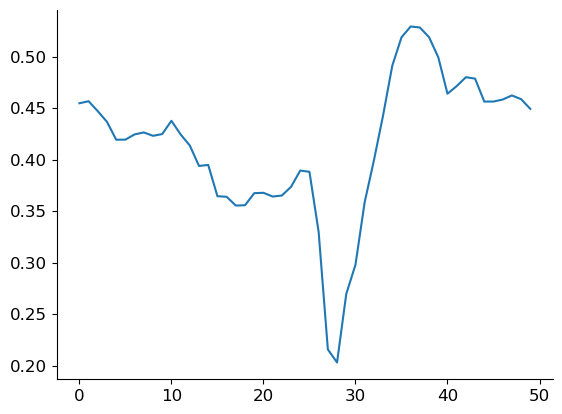

velocity_test.shape (50,)
AUC kernel input 0.9999999999999999


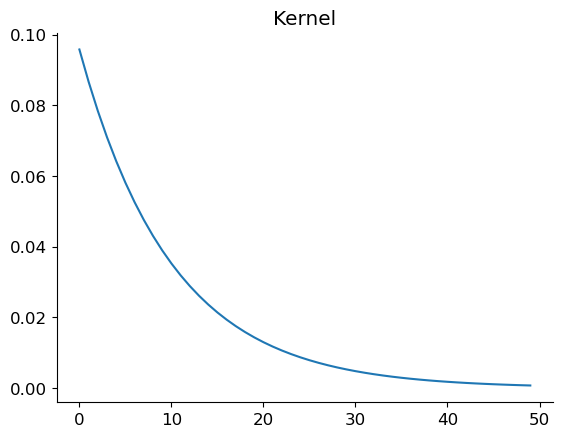

activity_test.shape (50,)


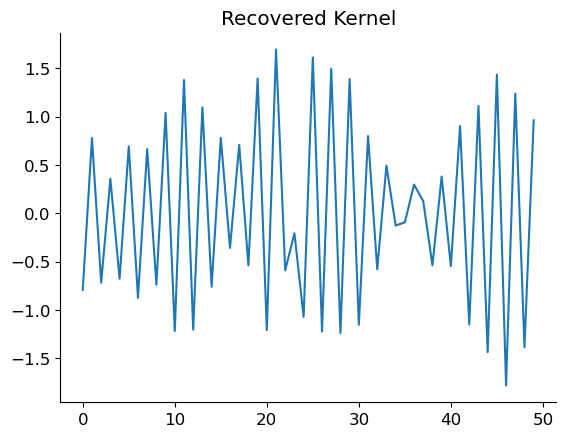

AUC recovered kernel 0.6768385604209166


In [101]:
# synthetic fourier transform 

### step 1 - make the artificial kernel 

from scipy.signal import convolve


def deconvolve_kernel_1d(neural_activity, velocity):
    
    neural_activity = neural_activity.flatten()
    velocity = velocity.flatten()
    
    
    SF = np.fft.fft(neural_activity)
    FF = np.fft.fft(velocity)
    
    GF = SF / (FF + 1e-6)
    
    kernel = np.fft.ifft(GF).real  # Take real part

    return kernel


velocity_test = np.mean(per_cell_velocity[0], axis=1)
plt.plot(velocity_test)
plt.show()
print(f"velocity_test.shape {velocity_test.shape}")
length_kernel = len(velocity_test)

def make_exponential_kernel(length=50, decay_rate=0.1):

    t = np.arange(length)
    kernel= np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)
    
    return kernel 

kernel_test = make_exponential_kernel(length=length_kernel, decay_rate=0.1)
print(f"AUC kernel input {np.sum(kernel_test)}")

plt.figure()
plt.plot(kernel_test)
plt.title("Kernel")
plt.show()

activity_test = convolve(kernel_test, velocity_test, mode="same")
# activity_test = activity_test[:len(velocity_test)]

print(f"activity_test.shape {activity_test.shape}")

recovered_kernel = deconvolve_kernel_1d(activity_test, velocity_test)

plt.figure()
plt.plot(recovered_kernel)
plt.title("Recovered Kernel")
plt.show()


print(f"AUC recovered kernel {np.sum(recovered_kernel)}")

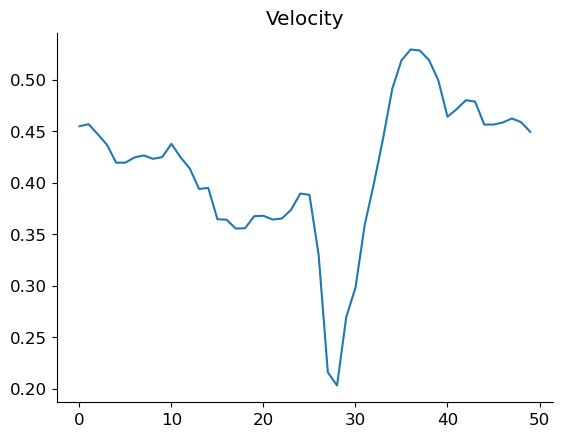

AUC Kernel Input: 0.9999999999999999


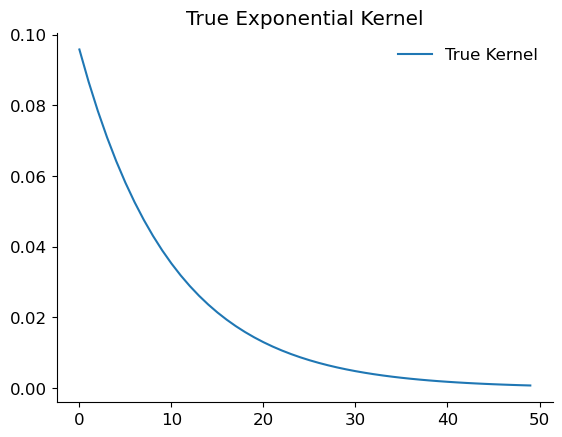

Activity shape: (50,)


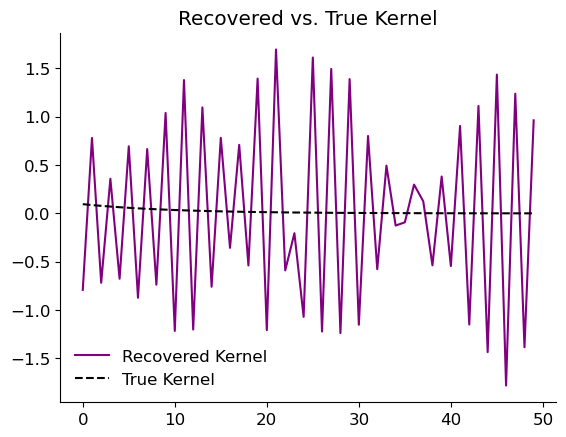

AUC Recovered Kernel: 0.6768385604209166


In [118]:
from scipy.signal import convolve
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def deconvolve_kernel_1d(neural_activity, velocity, regularizer=1e-6):

    neural_activity = neural_activity.flatten()
    velocity = velocity.flatten()

    SF = np.fft.fft(neural_activity)
    FF = np.fft.fft(velocity)

    GF = SF / (FF + regularizer)

    kernel = np.fft.ifft(GF).real 

#     kernel = gaussian_filter1d(kernel, sigma=1)

    return kernel

velocity_test = np.mean(per_cell_velocity[0], axis=1)
plt.figure()
plt.plot(velocity_test)
plt.title("Velocity")
plt.show()

def make_exponential_kernel(length=50, decay_rate=0.1):
    t = np.arange(length)
    kernel = np.exp(-decay_rate * t)
    kernel /= np.sum(kernel)  
    return kernel 

kernel_test = make_exponential_kernel(length=50, decay_rate=0.1)
print(f"AUC Kernel Input: {np.sum(kernel_test)}")

plt.figure()
plt.plot(kernel_test, label="True Kernel")
plt.title("True Exponential Kernel")
plt.legend()
plt.show()

activity_test = convolve(kernel_test, velocity_test, mode="same")  
print(f"Activity shape: {activity_test.shape}")

recovered_kernel = deconvolve_kernel_1d(activity_test, velocity_test)

plt.figure()
plt.plot(recovered_kernel[:50], label="Recovered Kernel", color="purple")
plt.plot(kernel_test, linestyle="--", label="True Kernel", color="black")
plt.legend()
plt.title("Recovered vs. True Kernel")
plt.show()

print(f"AUC Recovered Kernel: {np.sum(recovered_kernel)}")


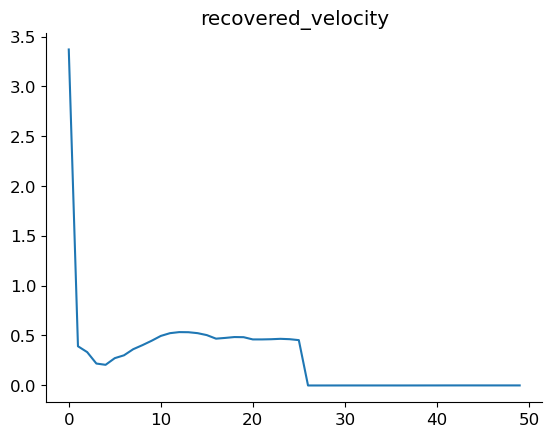

In [119]:
recovered_velocity = deconvolve_kernel_1d(activity_test, kernel_test)
 
plt.figure()
plt.plot(recovered_velocity)
plt.title("recovered_velocity")
plt.show()

C:\Users\Msfin\AppData\Local\Temp\ipykernel_28012\291529589.py:154: RuntimeWarning: divide by zero encountered in divide
  divide_data_by_velocity = np.where(velocity_quintile != 0, gaussian_quintile / velocity_quintile, np.nan)


ground_truth_q1.shape (50, 42)
Q0 MSE (Ground Truth - Residual)=0.697
Q1 MSE (Ground Truth - Residual)=0.288
Q2 MSE (Ground Truth - Residual)=0.111
Q3 MSE (Ground Truth - Residual)=0.160
Q4 MSE (Ground Truth - Residual)=0.451
Overall MSE All Quintiles 0.341


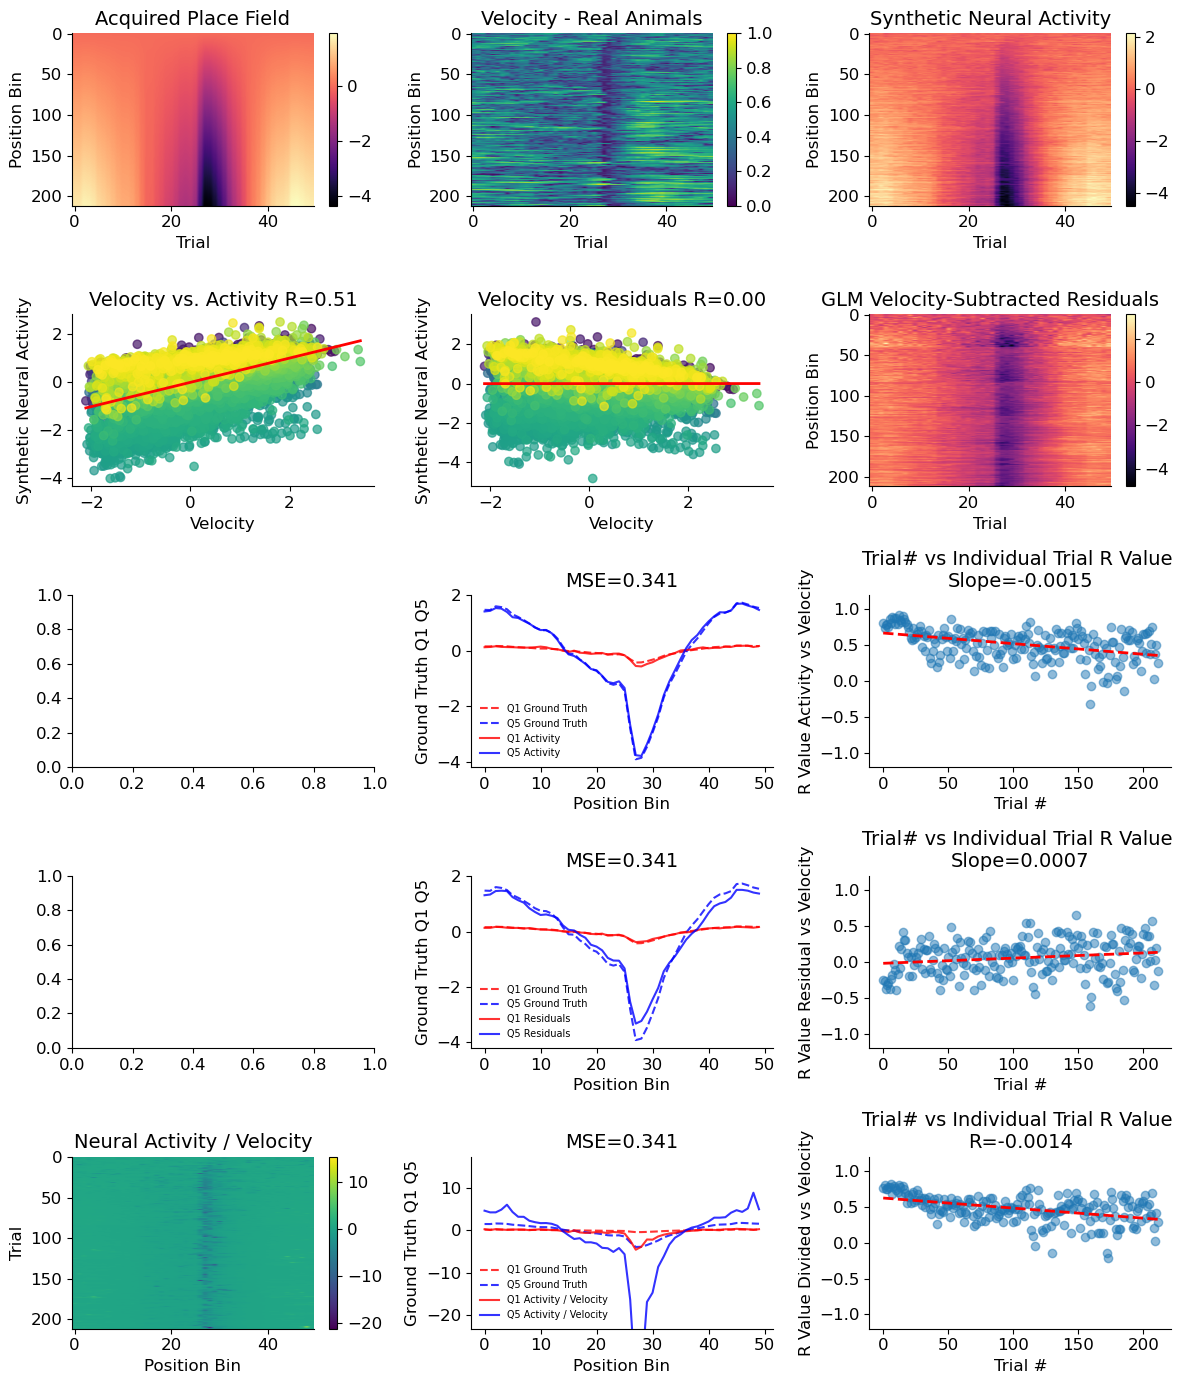

In [153]:
##### velocity plotted over cell trace

from sklearn.linear_model import RidgeCV
from pygam import LinearGAM
import matplotlib.cm as cm
from scipy.stats import linregress, pearsonr


def z_score_check_and_normalize(data, label):

    mean = np.mean(data)
    std = np.std(data)

    if np.isclose(mean, 0, atol=1e-2) and np.isclose(std, 1, atol=1e-2):
        return data  # No need to no
    elif std > 0:
        return (data - mean) / std  # Normalize
    else:
        return np.zeros_like(data)  # If variance is zero, return a zero array



def plot_synthetic_data_seperate_quintiles(weight_type, noise_sf, ramping_field=True, use_GAM=False, power=1, weight_scale=None, cell_type="SST"):
    
    
    if cell_type=="SST":

        per_cell_velocity = []
        for animal in activity_dict_SST:
            for neuron in activity_dict_SST[animal]:
                per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])
                
        num_trials=per_cell_velocity[0].shape[1]
        pf_scale = np.linspace(0, 1, num_trials)

        activity_list = []
        for animal in activity_dict_SST:
            for neuron in activity_dict_SST[animal]:
                activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

        neurons_array = np.stack(activity_list) 
        combined_gaussian = np.mean(neurons_array, axis=0)
        
    elif cell_type=="NDNF":

        per_cell_velocity = []
        for animal in activity_dict_NDNF:
            for neuron in activity_dict_NDNF[animal]:
                per_cell_velocity.append(factors_dict_NDNF[animal]['Velocity'])
                
        num_trials=per_cell_velocity[0].shape[1]
        pf_scale = np.linspace(0, 1, num_trials)

        activity_list = []
        for animal in activity_dict_NDNF:
            for neuron in activity_dict_NDNF[animal]:
                activity_list.append(np.mean(activity_dict_NDNF[animal][neuron], axis=1))

        neurons_array = np.stack(activity_list) 
        combined_gaussian = np.mean(neurons_array, axis=0)
    
    
    velocity = per_cell_velocity[0]
    
    if weight_type=="flat":
        weight = np.ones(num_trials)
    
    elif weight_type=="ramping_weight":
        weight = pf_scale
        
    elif weight_type=="step_weight":
        weight = np.zeros(num_trials)
        quint = len(weight) // 5  

        for i in range(5):
            weight[i * quint: (i + 1) * quint] = (i + 1) / 5

    weight = weight * weight_scale
    velocity_correlation = weight * velocity**(power) 
    
    
    a = np.tile(combined_gaussian, (num_trials, 1)).T
    if ramping_field:
        a = a * pf_scale
    a = (a-np.mean(a)) / np.std(a)
    
    noise = noise_sf * np.random.normal(0, 1, a.shape)
    
    combined_gaussian_with_velocity = a + velocity_correlation + noise
    std_dev = np.std(combined_gaussian_with_velocity)
    if std_dev == 0:
        combined_gaussian_with_velocity = combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)
    else:
        combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / std_dev
    

    num_trials = combined_gaussian_with_velocity.shape[1]  
    quintile_size = num_trials // 5  

    gaussian_quintiles = [] 
    velocity_quintiles = []
    ground_truth_qunitles_list = []

    for i in range(5):  
        start_idx = i * quintile_size 
        end_idx = (num_trials if i == 4 else (i + 1) * quintile_size)  
  

        gaussian_quintile = combined_gaussian_with_velocity[:, start_idx:end_idx] 
        gaussian_quintiles.append(gaussian_quintile) 
        
        velocity_quintile = velocity[:, start_idx:end_idx] 
        velocity_quintiles.append(velocity_quintile)
        
        ground_truth_qunitle = a[:, start_idx:end_idx]
        ground_truth_qunitles_list.append(ground_truth_qunitle)

    
    ################# Fitting Model (GLM or GAM)
    
    
    mean_residual_list = []
    mean_gaussian_list = []
    mean_divided_list = []
    
    residual_list = []
    gaussian_list = []
    divided_list = []
    velocity_list = []
    predicted_list = []
    
    for i in range(5):
        gaussian_quintile  = gaussian_quintiles[i]
        velocity_quintile = velocity_quintiles[i]
        
        neuron_activity_flat = gaussian_quintile.flatten()
        flattened_velocity = velocity_quintile.flatten().reshape(-1, 1)  

        if use_GAM:
            model = LinearGAM().fit(flattened_velocity, neuron_activity_flat)
            neuron_predicted_activity = model.predict(flattened_velocity)

        else:
            alphas = [0.1, 1, 10, 100, 1000, 5000]
            model = RidgeCV(alphas=alphas, cv=None)
            model.fit(flattened_velocity, neuron_activity_flat)
            neuron_predicted_activity = model.predict(flattened_velocity)
            
        
        neuron_predicted_activity = neuron_predicted_activity.reshape(velocity_quintile.shape)

        residual = gaussian_quintile - neuron_predicted_activity

        divide_data_by_velocity = np.where(velocity_quintile != 0, gaussian_quintile / velocity_quintile, np.nan)
        divide_data_by_velocity = np.nan_to_num(divide_data_by_velocity, nan=0)
        
        mean_residual_list.append(np.mean(residual, axis=1))
        mean_gaussian_list.append(np.mean(gaussian_quintile, axis=1))
        mean_divided_list.append(np.mean(divide_data_by_velocity, axis=1))

        gaussian_list.append(z_score_check_and_normalize(gaussian_quintile, "Combined Gaussian with Velocity"))
        velocity_list.append(z_score_check_and_normalize(velocity_quintile, "Velocity"))
        residual_list.append(z_score_check_and_normalize(residual, "Residuals"))
        divided_list.append(z_score_check_and_normalize(divide_data_by_velocity, "Velocity-Subtracted Activity"))
        predicted_list.append(z_score_check_and_normalize(neuron_predicted_activity, "Prediction"))

    
    residual_array = np.concatenate(residual_list, axis=1)
    gaussian_array = np.concatenate(gaussian_list, axis=1)
    divided_array = np.concatenate(divided_list, axis=1)
    velocity_array = np.concatenate(velocity_list, axis=1)
    predicted_array = np.concatenate(predicted_list, axis=1)
    
    mean_residual_array = np.concatenate(residual_list, axis=1)
    mean_gaussian_array = np.concatenate(gaussian_list, axis=1)
    mean_divided_array = np.concatenate(divided_list, axis=1)
    mean_velocity_array = np.concatenate(velocity_list, axis=1)

        
#     ################## overall correlations

    flat_velocity = velocity_array.flatten()
    flat_residual = residual_array.flatten()
    flat_activity = gaussian_array.flatten()
    
    velocity_activity_correlation, _ = pearsonr(flat_velocity, flat_activity)

    slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)

    x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals = slope * x_vals + intercept

    velocity_residual_correlation, _ = pearsonr(flat_velocity, flat_residual)
    slope_pred, intercept_pred, r_value_pred, p_value_pred, std_err_pred = linregress(flat_velocity, flat_residual)

    x_vals_pred = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
    y_vals_pred = slope_pred * x_vals_pred + intercept_pred
    

    ################### Trial by trial correlations 

    prediction_velocity_correlation_list = []
    activity_velocity_correlation_list = []
    residual_velocity_correlation_list = []
    divided_velocity_correlation_list = []

    for i in range(mean_gaussian_array.shape[1]):
        trial_predicted_activity = predicted_array[:, i]
        trial_velocity = velocity_array[:, i]
        trial_activity = gaussian_array[:, i]
        trial_residual = residual_array[:, i]
        trial_divided = divided_array[:, i]

        prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
        prediction_velocity_correlation_list.append(prediction_velocity_correlation)
        
        activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
        activity_velocity_correlation_list.append(activity_velocity_correlation)
        
        residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
        residual_velocity_correlation_list.append(residual_velocity_correlation)
        
        divided_velocity_correlation, _ = pearsonr(trial_divided, trial_velocity)
        divided_velocity_correlation_list.append(divided_velocity_correlation)

    #############################

    ground_truth_q1 = ground_truth_qunitles_list[0]
    print(f"ground_truth_q1.shape {ground_truth_q1.shape}")
    ground_truth_q5 = ground_truth_qunitles_list[4]

    mean_truth_q1 = np.mean(ground_truth_q1, axis=1)
    mean_truth_q5 = np.mean(ground_truth_q5, axis=1)

    fig, axs = plt.subplots(5, 3, figsize=(12, 14))  

    im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
    axs[0, 0].set_xlabel("Trial", fontsize=12)
    axs[0, 0].set_ylabel("Position Bin", fontsize=12)
    if ramping_field:
        axs[0, 0].set_title("Acquired Place Field", fontsize=14)
    else:
        axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
    fig.colorbar(im1, ax=axs[0, 0])
    
    
    MSE_by_quintile_list = []
    
    for i in range(5):
        MSE = (ground_truth_qunitles_list[i]-residual_list[i])**2
        MSE = np.mean(MSE)
        MSE_by_quintile_list.append(MSE)
        print(f"Q{i} MSE (Ground Truth - Residual)={MSE:.3f}")
        
    print(f"Overall MSE All Quintiles {np.mean(MSE_by_quintile_list):.3f}")
    

    im3 = axs[0, 1].imshow(velocity.T, cmap='viridis', aspect='auto')
    axs[0, 1].set_title("Velocity - Real Animals", fontsize=14)
    axs[0, 1].set_xlabel("Trial", fontsize=12)
    axs[0, 1].set_ylabel("Position Bin", fontsize=12)
    fig.colorbar(im3, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
    axs[0, 2].set_xlabel("Trial", fontsize=12)
    axs[0, 2].set_ylabel("Position Bin", fontsize=12)
    axs[0, 2].set_title("Synthetic Neural Activity", fontsize=14)
    fig.colorbar(im2, ax=axs[0, 2])

    num_points, num_trials = velocity.shape
    trial_colors = np.repeat(np.linspace(0,1,num_trials), num_points)
    
    cmap = plt.colormaps.get_cmap("viridis")
 
    sc = axs[1, 0].scatter(flat_velocity, flat_activity, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 0].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 0].set_xlabel("Velocity", fontsize=12)
    axs[1, 0].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 0].set_title(f"Velocity vs. Activity R={velocity_activity_correlation:.2f}", fontsize=14)


    sc = axs[1, 1].scatter(flat_velocity, flat_residual, c=[cmap(t) for t in trial_colors], alpha=0.7)
    axs[1, 1].plot(x_vals_pred, y_vals_pred, color='red', linewidth=2, label="Best Fit Line")
    axs[1, 1].set_xlabel("Velocity", fontsize=12)
    axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
    axs[1, 1].set_title(f"Velocity vs. Residuals R={velocity_residual_correlation:.2f}", fontsize=14)

    im5 = axs[1, 2].imshow(residual_array.T, cmap='magma', aspect='auto')
    axs[1, 2].set_xlabel("Trial", fontsize=12)
    axs[1, 2].set_ylabel("Position Bin", fontsize=12)
    axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
    fig.colorbar(im5, ax=axs[1, 2])


    data_list1 = [gaussian_list[0], gaussian_list[4], residual_list[0], residual_list[4], divided_list[0], divided_list[4]]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data1 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data1 = np.min(min_list)
    
    data_list2 = [activity_velocity_correlation_list, residual_velocity_correlation_list, divided_velocity_correlation_list]
    max_list = []
    for i in data_list1:
        max_val = np.max(i)
        max_list.append(max_val)
    max_list = np.array(max_list)
    max_data2 = np.max(max_list)

    min_list = []
    for i in data_list1:
        min_val = np.min(i)
        min_list.append(min_val)
    min_list = np.array(min_list)
    min_data2 = np.min(min_list)
    
    
    mean_corr_activity = np.mean(activity_velocity_correlation_list)
    mean_corr_residual = np.mean(residual_velocity_correlation_list)
    mean_corr_divide = np.mean(divided_velocity_correlation_list)

    axs[2, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Ground Truth", alpha=0.8)
    axs[2, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Ground Truth", alpha=0.8)
    axs[2, 1].plot(mean_gaussian_list[0], color='r', label="Q1 Activity", alpha=0.8)
    axs[2, 1].plot(mean_gaussian_list[4], color='b', label="Q5 Activity", alpha=0.8)
    axs[2, 1].set_xlabel("Position Bin", fontsize=12)
    axs[2, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[2, 1].set_title(f"MSE={np.mean(MSE_by_quintile_list):.3f}", fontsize=14)
    axs[2, 1].legend(fontsize=7)
    
    trial_numbers=np.arange(len(activity_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers

    axs[2, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
    axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[2, 2].set_xlabel("Trial #", fontsize=12)
    axs[2, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
    axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nSlope={slope:.4f}", fontsize=14)
    axs[2, 2].set_ylim(-1.2, 1.2)

    axs[3, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Ground Truth", alpha=0.8)
    axs[3, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Ground Truth", alpha=0.8)
    axs[3, 1].plot(mean_residual_list[0], color='r', label="Q1 Residuals", alpha=0.8)
    axs[3, 1].plot(mean_residual_list[4], color='b', label="Q5 Residuals", alpha=0.8)
    axs[3, 1].set_xlabel("Position Bin", fontsize=12)
    axs[3, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[3, 1].set_title(f"MSE={np.mean(MSE_by_quintile_list):.3f}", fontsize=14)
    axs[3, 1].legend(fontsize=7)
    
    trial_numbers=np.arange(len(residual_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    residual_corr_array = np.array(residual_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

    axs[3, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
    axs[3, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[3, 2].set_xlabel("Trial #", fontsize=12)
    axs[3, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
    axs[3, 2].set_title(f"Trial# vs Individual Trial R Value \nSlope={slope:.4f}", fontsize=14)
    axs[3, 2].set_ylim(-1.2, 1.2)


#############  Dividing by velocity - Christines original model 
    
    im = axs[4, 0].imshow(divided_array.T, aspect='auto')
    axs[4, 0].set_xlabel("Position Bin", fontsize=12)
    axs[4, 0].set_ylabel("Trial", fontsize=12)
    axs[4, 0].set_title("Neural Activity / Velocity", fontsize=14)
    plt.colorbar(im, ax=axs[4, 0])
    
    axs[4, 1].plot(mean_truth_q1, color='r', linestyle='dashed', label="Q1 Ground Truth", alpha=0.8)
    axs[4, 1].plot(mean_truth_q5, color='b', linestyle='dashed', label="Q5 Ground Truth", alpha=0.8)
    axs[4, 1].plot(mean_divided_list[0], color='r', label="Q1 Activity / Velocity", alpha=0.8)
    axs[4, 1].plot(mean_divided_list[4], color='b', label="Q5 Activity / Velocity", alpha=0.8)
    axs[4, 1].set_xlabel("Position Bin", fontsize=12)
    axs[4, 1].set_ylabel("Ground Truth Q1 Q5", fontsize=12)
    axs[4, 1].set_title(f"MSE={np.mean(MSE_by_quintile_list):.3f}", fontsize=14)
    axs[4, 1].set_ylim(min_data1-2, max_data1+2)
    axs[4, 1].legend(fontsize=7)
    
    trial_numbers=np.arange(len(divided_velocity_correlation_list))
    slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, divided_velocity_correlation_list)
    trend_line = intercept + slope*trial_numbers
    
    divided_corr_array = np.array(divided_velocity_correlation_list)
    r_value_over_trials, _ = pearsonr(trial_numbers, divided_corr_array)

    axs[4, 2].scatter(trial_numbers, divided_velocity_correlation_list, alpha=0.5, label="Data")
    axs[4, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
    axs[4, 2].set_xlabel("Trial #", fontsize=12)
    axs[4, 2].set_ylabel("R Value Divided vs Velocity", fontsize=12)
    axs[4, 2].set_title(f"Trial# vs Individual Trial R Value \nR={slope:.4f}", fontsize=14)
    axs[4, 2].set_ylim(-1.2, 1.2)

    
    
# # run a GLM with each quintile getting its own weight then plot the weights and means over laps 
    
    plt.tight_layout() 
    plt.show()

plot_synthetic_data_seperate_quintiles(weight_type="flat", noise_sf=0.1, ramping_field=True, use_GAM=False, power=1, weight_scale=1, cell_type="SST")

# #flat
# #weight="ramping_weight
# #weight="step_weight
# #### ramping wt still linear just chaning in scale with trial

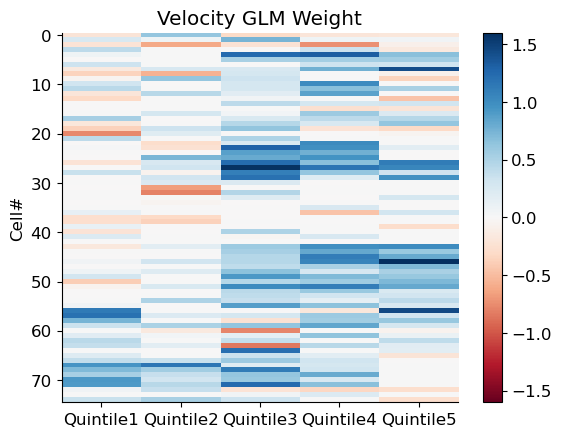

In [353]:


def get_weights_per_quintile(activity_dict_SST, use_GAM=False):
    per_cell_velocity = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])
            
    

    activity_list = []
    for animal in activity_dict_SST:
        for neuron in activity_dict_SST[animal]:
            activity_list.append(activity_dict_SST[animal][neuron])  

    each_cell_weights_list = []

    for idx, cell in enumerate(activity_list):
        num_trials = cell.shape[1]  
        quintile_size = num_trials // 5  

        gaussian_quintiles = [] 
        velocity_quintiles = []
        ground_truth_quintiles_list = []

        for i in range(5):  
            start_idx = i * quintile_size 
            end_idx = num_trials if i == 4 else (i + 1) * quintile_size  

            gaussian_quintile = cell[:, start_idx:end_idx] 
            gaussian_quintiles.append(gaussian_quintile) 

            velocity_quintile = per_cell_velocity[i][:, start_idx:end_idx] 
            velocity_quintiles.append(velocity_quintile)

            ground_truth_quintile = a[:, start_idx:end_idx]
            ground_truth_quintiles_list.append(ground_truth_quintile)

        weight_per_quintile_list = []

        for i in range(5):
            gaussian_quintile  = gaussian_quintiles[i]
            velocity_quintile = velocity_quintiles[i]

            neuron_activity_flat = gaussian_quintile.flatten()
            flattened_velocity = velocity_quintile.flatten().reshape(-1, 1)  

            if use_GAM:
                model = LinearGAM().fit(flattened_velocity, neuron_activity_flat)
                weight = model.coef_  
            else:
                alphas = [0.1, 1, 10, 100, 1000, 5000]
                model = RidgeCV(alphas=alphas, cv=None)
                model.fit(flattened_velocity, neuron_activity_flat)
                weight = model.coef_[0]

            weight_per_quintile_list.append(weight) 

        each_cell_weights_list.append(weight_per_quintile_list)
        
    return each_cell_weights_list

each_cell_weights_list = get_weights_per_quintile(activity_dict_SST, use_GAM=False)


def plot_weights_per_quintile(each_cell_weights_list):

    each_cell_weights_list_array = np.array(each_cell_weights_list)
    
    plt.imshow(each_cell_weights_list_array, aspect="auto", cmap='RdBu', vmin=-1.6, vmax=1.6)
    plt.xticks(ticks=np.arange(5), labels=[f"Quintile{i+1}" for i in range(5)])
    plt.ylabel("Cell#")
    plt.title("Velocity GLM Weight")
    plt.colorbar()
    plt.plot()

plot_weights_per_quintile(each_cell_weights_list)



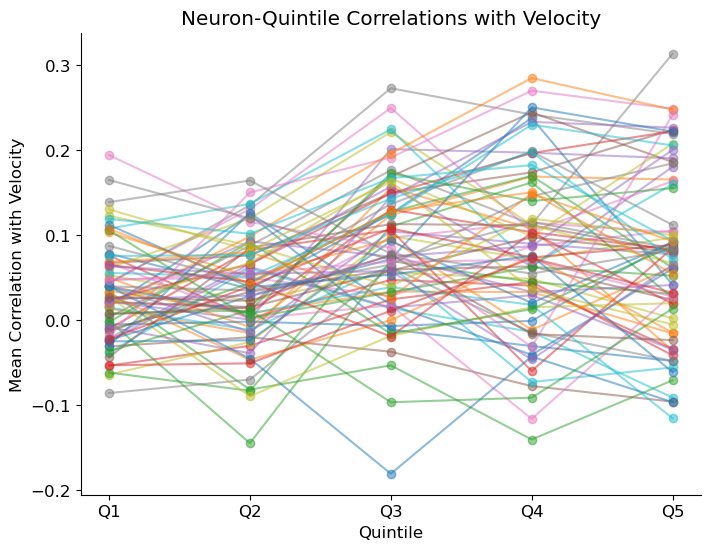

In [157]:
# per_cell_velocity = []
# for animal in activity_dict_SST:
#     for neuron in activity_dict_SST[animal]:
#         per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])


# activity_list = []
# for animal in activity_dict_SST:
#     for neuron in activity_dict_SST[animal]:
#         activity_list.append(activity_dict_SST[animal][neuron])  

all_cell_quintiles_correlation = []

for idx, cell in enumerate(activity_list):
    num_trials = cell.shape[1]  
    quintile_size = num_trials // 5  

#     gaussian_quintiles = [] 
#     velocity_quintiles = []
#     ground_truth_quintiles_list = []

    per_cell_quintiles_correlation = []

    for i in range(5):  
        start_idx = i * quintile_size 
        end_idx = num_trials if i == 4 else (i + 1) * quintile_size  

        activity_quintile = cell[:, start_idx:end_idx] 
        
        velocity_quintile = per_cell_velocity[i][:, start_idx:end_idx] 
        
        trial_correlations_within_quintile = []
        
        for trial_id in range(activity_quintile.shape[1]):
            trial_activity = activity_quintile[:, trial_id]
            trial_velocity = velocity_quintile[:, trial_id]
            
            trial_activity_vel_corr, _ = pearsonr(trial_activity, trial_velocity)
            
            trial_correlations_within_quintile.append(trial_activity_vel_corr)
        
        per_cell_quintiles_correlation.append(np.mean(trial_correlations_within_quintile))
        
    all_cell_quintiles_correlation.append(per_cell_quintiles_correlation)
            


quintile_correlation_array = np.array(all_cell_quintiles_correlation)  

quintiles = np.arange(1, 6)  

plt.figure(figsize=(8, 6))

for cell_correlations in quintile_correlation_array:
    plt.plot(quintiles, cell_correlations, alpha=0.5, linestyle='-', marker='o')

plt.xticks(quintiles, labels=[f"Q{i}" for i in quintiles])  
plt.xlabel("Quintile")
plt.ylabel("Mean Correlation with Velocity")
plt.title("Neuron-Quintile Correlations with Velocity")

plt.show()

        
    

     

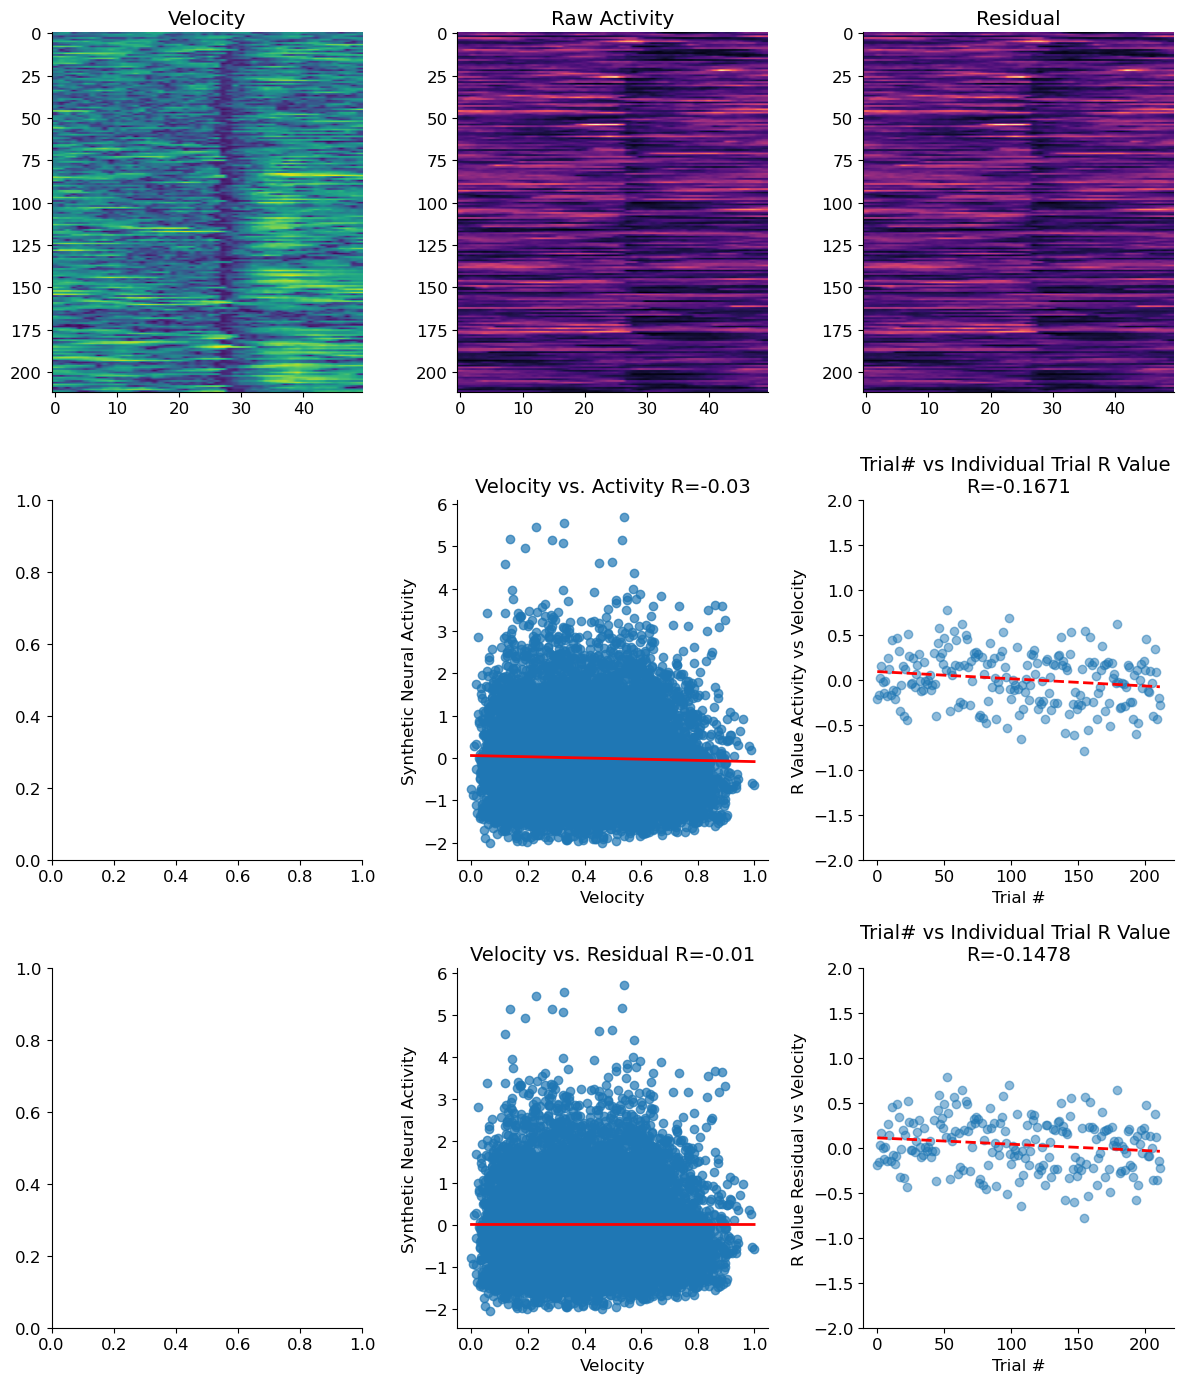

In [149]:

neuron_activity_list, predictions_list, cell_residual_list = get_neuron_activity_prediction_residual(activity_dict_SST, predicted_activity_dict_SST)
velocity = per_cell_velocity[0]
activity = neuron_activity_list[0]
residual = cell_residual_list[0]
prediction = predictions_list[0]

fig, axs = plt.subplots(3,3,  figsize=(12, 14))

axs[0, 0].imshow(velocity.T, aspect="auto")
axs[0, 0].set_title("Velocity")

axs[0, 1].imshow(activity.T, aspect="auto", cmap='magma')
axs[0, 1].set_title("Raw Activity")

axs[0, 2].imshow(residual.T, aspect="auto", cmap='magma')
axs[0, 2].set_title("Residual")

prediction_velocity_correlation_list = []
activity_velocity_correlation_list = []
residual_velocity_correlation_list = []

for i in range(activity.shape[1]):
    trial_predicted_activity = prediction[:, i]
    trial_velocity = velocity[:, i]
    trial_activity = activity[:, i]
    trial_residual = residual[:, i]

    prediction_velocity_correlation, _ = pearsonr(trial_predicted_activity, trial_velocity)
    prediction_velocity_correlation_list.append(prediction_velocity_correlation)

    activity_velocity_correlation, _ = pearsonr(trial_activity, trial_velocity)
    activity_velocity_correlation_list.append(activity_velocity_correlation)

    residual_velocity_correlation, _ = pearsonr(trial_residual, trial_velocity)
    residual_velocity_correlation_list.append(residual_velocity_correlation)
    
    
    
    
    
num_trials = residual.shape[1] 
quintile_size = num_trials // 5

divide_data_by_velocity = np.where(velocity != 0, combined_gaussian_with_velocity / velocity, 0)

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

activity_q1 = activity[:, :quintile_size]
activity_q5 = activity[:, -quintile_size:]

divided_q1 = divide_data_by_velocity[:, :quintile_size]
divided_q5 = divide_data_by_velocity[:, -quintile_size:]

mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_activity_q1 = np.mean(activity_q1, axis=1)
mean_activity_q5 = np.mean(activity_q5, axis=1)

mean_divided_q1 = np.mean(divided_q1, axis=1)
mean_divided_q5 = np.mean(divided_q5, axis=1)



axs[1, 0].plot(mean_activity_q1, color='r', label="Q1 Activity", marker='o', markersize=3, alpha=0.8)
axs[1, 0].plot(mean_activity_q5, color='b', label="Q5 Activity", marker='x', markersize=3, alpha=0.8)
axs[1, 0].set_xlabel("Position Bin", fontsize=12)
axs[1, 0].set_ylabel("Mean Activity", fontsize=12)
axs[1, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[1, 0].set_ylim(min_data1-0.2, max_data1+0.2)
axs[1, 0].legend(fontsize=10)
    
flat_velocity = velocity.flatten()
flat_activity = activity.flatten()

slope, intercept, r_value, p_value, std_err = linregress(flat_velocity, flat_activity)
x_vals = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals = slope * x_vals + intercept

velocity_activity_corr, _ = pearsonr(flat_velocity, flat_activity)
axs[1, 1].scatter(flat_velocity, flat_activity, alpha=0.7)
axs[1, 1].plot(x_vals, y_vals, color='red', linewidth=2, label="Best Fit Line")
axs[1, 1].set_xlabel("Velocity", fontsize=12)
axs[1, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[1, 1].set_title(f"Velocity vs. Activity R={velocity_activity_corr:.2f}", fontsize=14)
    
    
    
trial_numbers=np.arange(len(activity_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, activity_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

activity_corr_array = np.array(activity_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, activity_corr_array)

axs[1, 2].scatter(trial_numbers, activity_velocity_correlation_list, alpha=0.5, label="Data")
axs[1, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[1, 2].set_xlabel("Trial #", fontsize=12)
axs[1, 2].set_ylabel("R Value Activity vs Velocity", fontsize=12)
axs[1, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[1, 2].set_ylim(-2, 2)





    
flat_velocity = velocity.flatten()
flat_residual = residual.flatten()

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(flat_velocity, flat_residual)
x_vals2 = np.linspace(flat_velocity.min(), flat_velocity.max(), 100)
y_vals2 = slope * x_vals + intercept2

velocity_residual_corr, _ = pearsonr(flat_velocity, flat_residual)
axs[2, 1].scatter(flat_velocity, flat_residual, alpha=0.7)
axs[2, 1].plot(x_vals2, y_vals2, color='red', linewidth=2, label="Best Fit Line")
axs[2, 1].set_xlabel("Velocity", fontsize=12)
axs[2, 1].set_ylabel("Synthetic Neural Activity", fontsize=12)
axs[2, 1].set_title(f"Velocity vs. Residual R={velocity_residual_corr:.2f}", fontsize=14)


    
    
trial_numbers=np.arange(len(residual_velocity_correlation_list))
slope, intercept, r_value, p_value, std_err = linregress(trial_numbers, residual_velocity_correlation_list)
trend_line = intercept + slope*trial_numbers

residual_corr_array = np.array(residual_velocity_correlation_list)
r_value_over_trials, _ = pearsonr(trial_numbers, residual_corr_array)

axs[2, 2].scatter(trial_numbers, residual_velocity_correlation_list, alpha=0.5, label="Data")
axs[2, 2].plot(trial_numbers, trend_line, color="red", linewidth=2, linestyle="dashed", label=f"Trend (slope={slope:.4f})")
axs[2, 2].set_xlabel("Trial #", fontsize=12)
axs[2, 2].set_ylabel("R Value Residual vs Velocity", fontsize=12)
axs[2, 2].set_title(f"Trial# vs Individual Trial R Value \nR={r_value_over_trials:.4f}", fontsize=14)
axs[2, 2].set_ylim(-2, 2)












plt.tight_layout()
plt.show()




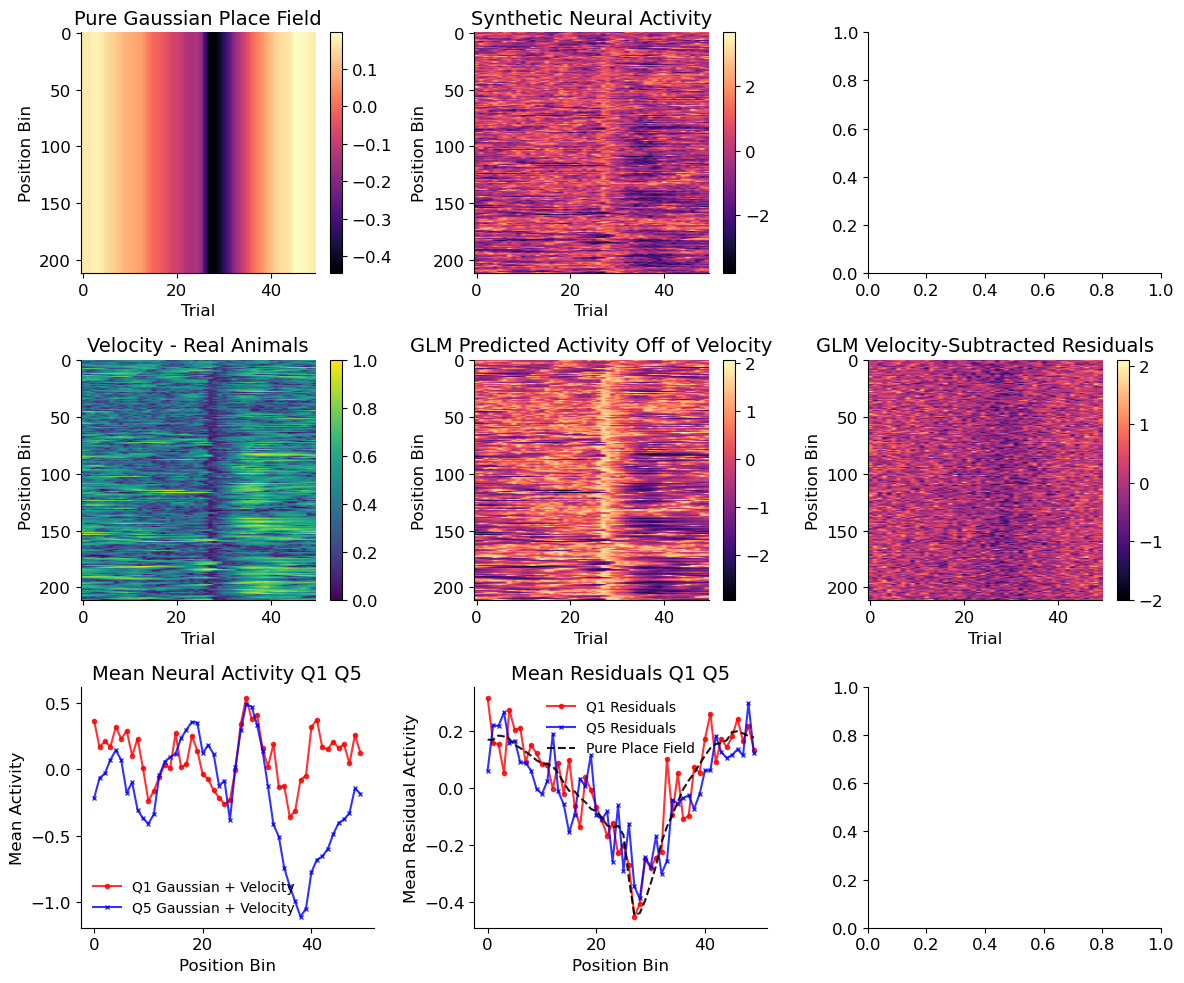

In [5]:
##### velocity plotted over cell trace

weight = -5
noise_sf = 0.5
pf_scale = np.linspace(0, 1, 212)
# pf_position = 


per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)

num_trials = per_cell_velocity[0].shape[1]


################# plotting pure gaussian place fields

a = np.tile(combined_gaussian, (num_trials, 1)).T

################# pure velocity data

velocity = per_cell_velocity[0]

################# plotting velocity-correlated activity


velocity_correlation = weight*velocity

combined_gaussian_with_velocity = a + velocity_correlation

combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

noise = noise_sf * np.random.normal(0, 1, a.shape)
combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise


################# fitting a GLM and getting velocity prediction 

neuron_activity_flat = combined_gaussian_with_velocity.flatten()
flattened_data = velocity.flatten()

alphas=None

model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)


################## plotting the residuals 

residual = combined_gaussian_with_velocity - neuron_predicted_activity


################## plotting quintiles 


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  # First 1/5th
residual_q5 = residual[:, -quintile_size:]  # Last 1/5th

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


mean_residual_q1 = np.mean(residual_q1, axis=1)
mean_residual_q5 = np.mean(residual_q5, axis=1)

mean_gaussian_q1 = np.mean(gaussian_q1, axis=1)
mean_gaussian_q5 = np.mean(gaussian_q5, axis=1)


#############################

fig, axs = plt.subplots(3, 3, figsize=(12, 10))  # Increase figure size

im1 = axs[0, 0].imshow(a.T, cmap='magma', aspect='auto')
axs[0, 0].set_xlabel("Trial", fontsize=12)
axs[0, 0].set_ylabel("Position Bin", fontsize=12)
axs[0, 0].set_title("Pure Gaussian Place Field", fontsize=14)
fig.colorbar(im1, ax=axs[0, 0])

im2 = axs[0, 1].imshow(combined_gaussian_with_velocity.T, cmap='magma', aspect='auto')
axs[0, 1].set_xlabel("Trial", fontsize=12)
axs[0, 1].set_ylabel("Position Bin", fontsize=12)
axs[0, 1].set_title("Synthetic Neural Activity", fontsize=14)
fig.colorbar(im2, ax=axs[0, 1])

im3 = axs[1, 0].imshow(velocity.T, cmap='viridis', aspect='auto')
axs[1, 0].set_title("Velocity - Real Animals", fontsize=14)
axs[1, 0].set_xlabel("Trial", fontsize=12)
axs[1, 0].set_ylabel("Position Bin", fontsize=12)
fig.colorbar(im3, ax=axs[1, 0])

im4 = axs[1, 1].imshow(neuron_predicted_activity.T, cmap='magma', aspect='auto')
axs[1, 1].set_xlabel("Trial", fontsize=12)
axs[1, 1].set_ylabel("Position Bin", fontsize=12)
axs[1, 1].set_title("GLM Predicted Activity Off of Velocity", fontsize=14)
fig.colorbar(im4, ax=axs[1, 1])

im5 = axs[1, 2].imshow(residual.T, cmap='magma', aspect='auto')
axs[1, 2].set_xlabel("Trial", fontsize=12)
axs[1, 2].set_ylabel("Position Bin", fontsize=12)
axs[1, 2].set_title("GLM Velocity-Subtracted Residuals", fontsize=14)
fig.colorbar(im5, ax=axs[1, 2])

axs[2, 0].plot(mean_gaussian_q1, color='r', label="Q1 Gaussian + Velocity", marker='o', markersize=3, alpha=0.8)
axs[2, 0].plot(mean_gaussian_q5, color='b', label="Q5 Gaussian + Velocity", marker='x', markersize=3, alpha=0.8)
axs[2, 0].set_xlabel("Position Bin", fontsize=12)
axs[2, 0].set_ylabel("Mean Activity", fontsize=12)
axs[2, 0].set_title("Mean Neural Activity Q1 Q5", fontsize=14)
axs[2, 0].legend(fontsize=10)

axs[2, 1].plot(mean_residual_q1, color='r', label="Q1 Residuals", marker='o', markersize=3, alpha=0.8)
axs[2, 1].plot(mean_residual_q5, color='b', label="Q5 Residuals", marker='x', markersize=3, alpha=0.8)
axs[2, 1].plot(combined_gaussian, color="k", label="Pure Place Field", linestyle="--", alpha=0.9)
axs[2, 1].set_xlabel("Position Bin", fontsize=12)
axs[2, 1].set_ylabel("Mean Residual Activity", fontsize=12)
axs[2, 1].set_title("Mean Residuals Q1 Q5", fontsize=14)
axs[2, 1].legend(fontsize=10)

plt.tight_layout() 
plt.show()



residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_q1.shape (50, 42)
velocity_q1.shape (50, 42)
gaussian_q1.shape (50, 42)
velocity_q1.shape (50, 42)
residual_vel_corr_pos_q1 [-0.0076497057076108455, -0.012036099640309756, 0.02450870221599025]
residual_vel_corr_pos_q5 [-0.03662737347023687, -0.020470508843963727, -0.021610943728932873]
residual_vel_corr_neg_q1 []
residual_vel_corr_neg_q5 []


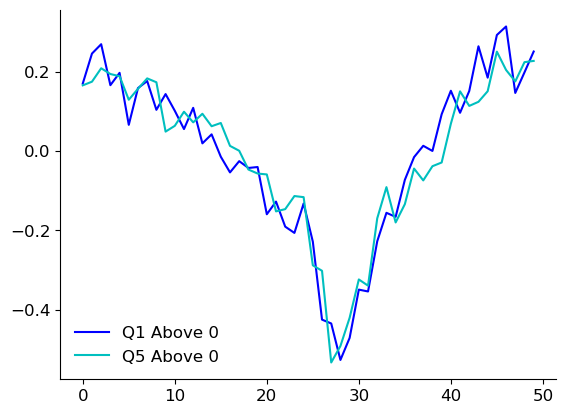

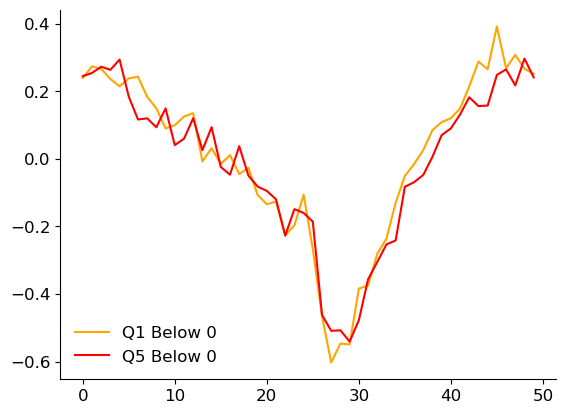

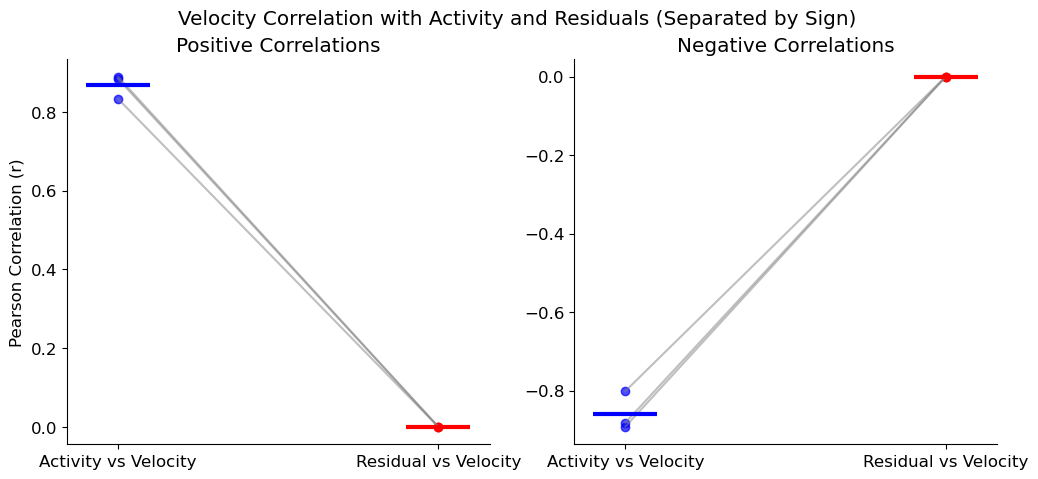

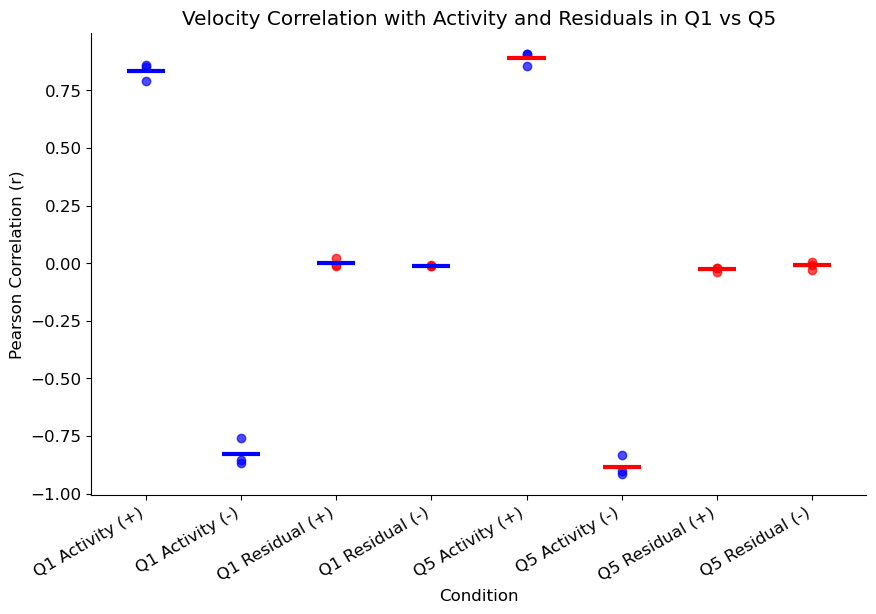

In [103]:
noise_sf=0.5

per_cell_velocity = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        per_cell_velocity.append(factors_dict_SST[animal]['Velocity'])

        
x = np.arange(50)

activity_list = []

for animal in activity_dict_SST:
    for neuron in activity_dict_SST[animal]:
        activity_list.append(np.mean(activity_dict_SST[animal][neuron], axis=1))

neurons_array = np.stack(activity_list) 
combined_gaussian = np.mean(neurons_array, axis=0)
combined_gaussian = np.tile(combined_gaussian, (num_trials, 1)).T


weights_list_positive = [2, 5, 10]
weights_list_negative = [-2, -5, -10]

gaussian_positive = []
gaussian_negative = []

for weight in weights_list_positive:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_positive.append(combined_gaussian_with_velocity.T)
    
for weight in weights_list_negative:
    velocity_correlation = weight*velocity

    combined_gaussian_with_velocity = combined_gaussian + velocity_correlation.T

    combined_gaussian_with_velocity = (combined_gaussian_with_velocity - np.mean(combined_gaussian_with_velocity)) / np.std(combined_gaussian_with_velocity)

    noise = noise_sf * np.random.normal(0, 1, a.shape).T
    combined_gaussian_with_velocity = combined_gaussian_with_velocity + noise
    gaussian_negative.append(combined_gaussian_with_velocity.T)
    

    
velocity = per_cell_velocity[0].T

positive_prediction_list = []
negative_prediction_list = []

for i in gaussian_positive:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    positive_prediction_list.append(neuron_predicted_activity)
    
for i in gaussian_negative:
    neuron_activity_flat = i.flatten()
    flattened_data = velocity.flatten()

    alphas=None

    model = RidgeCV(alphas=alphas if alphas is not None else [0.1, 1, 10, 100, 1000, 5000], cv=None)

    model.fit(flattened_data.reshape(-1, 1), neuron_activity_flat)

    neuron_predicted_activity = model.predict(flattened_data.reshape(-1, 1))

    neuron_predicted_activity = neuron_predicted_activity.reshape(velocity.shape)
    negative_prediction_list.append(neuron_predicted_activity)
    
residuals_list_positive = np.subtract(gaussian_positive, positive_prediction_list)
residuals_list_negative = np.subtract(gaussian_negative, negative_prediction_list)


num_trials = residual.shape[1] 
quintile_size = num_trials // 5

residual_q1 = residual[:, :quintile_size]  
residual_q5 = residual[:, -quintile_size:] 

gaussian_q1 = combined_gaussian_with_velocity[:, :quintile_size]
gaussian_q5 = combined_gaussian_with_velocity[:, -quintile_size:]


residual_list_pos_q1 = []
residual_list_pos_q5 = []
mean_residual_list_pos_q1 = []
mean_residual_list_pos_q5 = []

residual_vel_corr_pos_q1 = []
residual_vel_corr_pos_q5 = []
activity_vel_corr_pos_q1 = []
activity_vel_corr_pos_q5 = []

for idx, i in enumerate(residuals_list_positive):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    print(f"residual_q1.shape {residual_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    residual_list_pos_q1.append(residual_q1)
    residual_list_pos_q5.append(residual_q5)
    mean_residual_list_pos_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_pos_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    
    residual_vel_corr_pos_q1.append(q1_corr)
    residual_vel_corr_pos_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_positive[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_positive[idx].T[:, -quintile_size:] 
    
    print(f"gaussian_q1.shape {gaussian_q1.shape}")
    print(f"velocity_q1.shape {velocity_q1.shape}")
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_pos_q1.append(q1_corr_activity)
    activity_vel_corr_pos_q5.append(q5_corr_activity)
    
print(f"residual_vel_corr_pos_q1 {residual_vel_corr_pos_q1}")
print(f"residual_vel_corr_pos_q5 {residual_vel_corr_pos_q5}")
    
    
residual_list_neg_q1 = []
residual_list_neg_q5 = []
mean_residual_list_neg_q1 = []
mean_residual_list_neg_q5 = []

residual_vel_corr_neg_q1 = []
residual_vel_corr_neg_q5 = []
activity_vel_corr_neg_q1 = []
activity_vel_corr_neg_q5 = []

print(f"residual_vel_corr_neg_q1 {residual_vel_corr_neg_q1}")
print(f"residual_vel_corr_neg_q5 {residual_vel_corr_neg_q5}")

for idx, i in enumerate(residuals_list_negative):
    residual_q1 = i.T[:, :quintile_size]  
    residual_q5 = i.T[:, -quintile_size:]
    velocity_q1 = velocity.T[:, :quintile_size]  
    velocity_q5 = velocity.T[:, -quintile_size:]
    residual_list_neg_q1.append(residual_q1)
    residual_list_neg_q5.append(residual_q5)
    mean_residual_list_neg_q1.append(np.mean(residual_q1, axis=1))
    mean_residual_list_neg_q5.append(np.mean(residual_q5, axis=1))
    q1_corr, _ = pearsonr(residual_q1.flatten(), velocity_q1.flatten())
    q5_corr, _ = pearsonr(residual_q5.flatten(), velocity_q5.flatten())
    residual_vel_corr_neg_q1.append(q1_corr)
    residual_vel_corr_neg_q5.append(q5_corr)
    
    gaussian_q1 = gaussian_negative[idx].T[:, :quintile_size]  
    gaussian_q5 = gaussian_negative[idx].T[:, -quintile_size:]
    
    q1_corr_activity, _ = pearsonr(gaussian_q1.flatten(), velocity_q1.flatten())
    q5_corr_activity, _ = pearsonr(gaussian_q5.flatten(), velocity_q5.flatten())
    activity_vel_corr_neg_q1.append(q1_corr_activity)
    activity_vel_corr_neg_q5.append(q5_corr_activity)
    
        
        
activity_velocity_positive = []
activity_velocity_negative = []

residual_velocity_positive = []
residual_velocity_negative = []


for i in range(len(residual_list_pos_q1)):
    raw_positive = gaussian_positive[i].flatten()
    raw_negative = gaussian_negative[i].flatten()
    res_pos = residuals_list_positive[i].flatten()
    res_neg = residuals_list_negative[i].flatten()
    flat_velocity = velocity.flatten()
    positive_correlation, _ = pearsonr(raw_positive, flat_velocity)
    negative_correlation, _ = pearsonr(raw_negative, flat_velocity)
    activity_velocity_positive.append(positive_correlation)
    activity_velocity_negative.append(negative_correlation)
    res_pos_corr, _ = pearsonr(res_pos, flat_velocity)
    res_neg_corr, _ = pearsonr(res_neg, flat_velocity)
    residual_velocity_positive.append(res_pos_corr)
    residual_velocity_negative.append(res_neg_corr)

    
mean_residual_list_pos_q1_array = np.stack(mean_residual_list_pos_q1)
mean_residual_list_pos_q1_array = np.mean(mean_residual_list_pos_q1_array, axis=0)

mean_residual_list_pos_q5_array = np.stack(mean_residual_list_pos_q5)
mean_residual_list_pos_q5_array = np.mean(mean_residual_list_pos_q5_array, axis=0)

mean_residual_list_neg_q1_array = np.stack(mean_residual_list_neg_q1)
mean_residual_list_neg_q1_array = np.mean(mean_residual_list_neg_q1_array, axis=0)

mean_residual_list_neg_q5_array = np.stack(mean_residual_list_neg_q5)
mean_residual_list_neg_q5_array = np.mean(mean_residual_list_neg_q5_array, axis=0)


plt.figure()
plt.plot(mean_residual_list_pos_q1_array, color='b', label="Q1 Above 0")
plt.plot(mean_residual_list_pos_q5_array, color='c', label="Q5 Above 0")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_residual_list_neg_q1_array, color='orange', label="Q1 Below 0")
plt.plot(mean_residual_list_neg_q5_array, color='r', label="Q5 Below 0")
plt.legend()
plt.show()

#############################################################


min_len_pos = min(len(activity_velocity_positive), len(residual_velocity_positive))
min_len_neg = min(len(activity_velocity_negative), len(residual_velocity_negative))

# Truncate lists to match the minimum length
activity_velocity_positive = activity_velocity_positive[:min_len_pos]
residual_velocity_positive = residual_velocity_positive[:min_len_pos]

activity_velocity_negative = activity_velocity_negative[:min_len_neg]
residual_velocity_negative = residual_velocity_negative[:min_len_neg]

# Define x positions for Activity vs Velocity (x=1) and Residual vs Velocity (x=2)
x_pos_activity = np.full(len(activity_velocity_positive), 1)
x_pos_residual = np.full(len(residual_velocity_positive), 2)

x_neg_activity = np.full(len(activity_velocity_negative), 1)
x_neg_residual = np.full(len(residual_velocity_negative), 2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Positive Correlations Plot
axes[0].scatter(x_pos_activity, activity_velocity_positive, color='b', alpha=0.7, label="Activity Positive")
axes[0].scatter(x_pos_residual, residual_velocity_positive, color='r', alpha=0.7, label="Residual Positive")

for i in range(len(activity_velocity_positive)):
    axes[0].plot([1, 2], [activity_velocity_positive[i], residual_velocity_positive[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[0].hlines(np.mean(activity_velocity_positive), 0.9, 1.1, color='b', linewidth=3)
axes[0].hlines(np.mean(residual_velocity_positive), 1.9, 2.1, color='r', linewidth=3)

axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[0].set_ylabel("Pearson Correlation (r)")
axes[0].set_title("Positive Correlations")

# Negative Correlations Plot
axes[1].scatter(x_neg_activity, activity_velocity_negative, color='b', alpha=0.7, label="Activity Negative")
axes[1].scatter(x_neg_residual, residual_velocity_negative, color='r', alpha=0.7, label="Residual Negative")

for i in range(len(activity_velocity_negative)):
    axes[1].plot([1, 2], [activity_velocity_negative[i], residual_velocity_negative[i]], color='gray', alpha=0.5)

# Mean horizontal lines
axes[1].hlines(np.mean(activity_velocity_negative), 0.9, 1.1, color='b', linewidth=3)
axes[1].hlines(np.mean(residual_velocity_negative), 1.9, 2.1, color='r', linewidth=3)

axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(["Activity vs Velocity", "Residual vs Velocity"])
axes[1].set_title("Negative Correlations")

plt.suptitle("Velocity Correlation with Activity and Residuals (Separated by Sign)")
plt.show()



#####################################################################

q1_corr_values = [
    activity_vel_corr_pos_q1, activity_vel_corr_neg_q1,
    residual_vel_corr_pos_q1, residual_vel_corr_neg_q1
]

q5_corr_values = [
    activity_vel_corr_pos_q5, activity_vel_corr_neg_q5,
    residual_vel_corr_pos_q5, residual_vel_corr_neg_q5
]

labels = ["Q1 Activity (+)", "Q1 Activity (-)", "Q1 Residual (+)", "Q1 Residual (-)",
          "Q5 Activity (+)", "Q5 Activity (-)", "Q5 Residual (+)", "Q5 Residual (-)"]

x_positions_q1 = np.arange(1, 5)
x_positions_q5 = np.arange(5, 9)

plt.figure(figsize=(10, 6))

# Plot Q1 correlations
for i, data in enumerate(q1_corr_values):
    plt.scatter([x_positions_q1[i]] * len(data), data, color='b' if "Activity" in labels[i] else 'r', alpha=0.7)

# Plot Q5 correlations
for i, data in enumerate(q5_corr_values):
    plt.scatter([x_positions_q5[i]] * len(data), data, color='b' if "Activity" in labels[i + 4] else 'r', alpha=0.7)

# Mean lines
means_q1 = [np.mean(data) for data in q1_corr_values]
means_q5 = [np.mean(data) for data in q5_corr_values]

plt.hlines(means_q1, x_positions_q1 - 0.2, x_positions_q1 + 0.2, color='b', linewidth=3)
plt.hlines(means_q5, x_positions_q5 - 0.2, x_positions_q5 + 0.2, color='r', linewidth=3)

plt.xticks(np.concatenate([x_positions_q1, x_positions_q5]), labels, rotation=30, ha="right")
plt.xlabel("Condition")
plt.ylabel("Pearson Correlation (r)")
plt.title("Velocity Correlation with Activity and Residuals in Q1 vs Q5")
plt.show()

